In [1]:
# Import packages
import pandas as pd
import numpy as np
import numpy_financial as npf
from fredapi import Fred
from scipy.optimize import minimize
from matplotlib import pyplot as plt

# Let's collect GDP and CPI Data for our Macroeconomic Analysis

In [2]:
# initialize Fred API
# Note: To use FRED API you must register an account and receive an api_key
fred = Fred(api_key = 'xxx') 

In [3]:
# Set Date index for Fred Pull
start = "01/01/1970"
end = "03/31/2025"

In [4]:
# Pull GDP data
gdp_data = fred.get_series("GDPC1", observation_start = start, observation_end = end, frequency="a")

In [5]:
# Calculate growth rate and format dataframe
GDP = pd.DataFrame(gdp_data)
GDP["GDP YoY"] = (GDP[0] - GDP[0].shift(1)) / GDP[0].shift(1)
GDP.drop(columns=0, inplace=True)
GDP.rename(columns={"GDP YoY" : "GDP"})
GDP.index = GDP.index.year # switch to only show year
GDP = GDP.dropna() # drop first row

In [6]:
# Pull CPI Data
cpi_data = fred.get_series("CPIAUCSL", observation_start = start, observation_end = end, frequency="a")

In [7]:
CPI = pd.DataFrame(cpi_data)
CPI["CPI YoY"] = (CPI[0] - CPI[0].shift(1)) / CPI[0].shift(1)
CPI.drop(columns=0, inplace=True)
CPI.rename(columns={"CPI YoY" : "CPI"})
CPI.index = CPI.index.year # switch to only show year
CPI = CPI.dropna() # drop first row

# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# We Start our Analysis in 1971 and with 5 assets
# Assets: Gold, SP500, NIKKEI, US 10Y, UK 10Y
# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Get Return Data

In [8]:
# Import Data Set
data = pd.read_csv("monthly_macro_data_1971.csv")
data = data.set_index("Date")
data = data.dropna()
original_columns = data.columns.to_list() # export column names for later use

In [9]:
data

,Gold,SP500,US 10Y,UK 10Y,USDJPY,GBPUSD,NIKKEI
Date,,,,,,,
12/31/1970,35.17,91.110000,6.50,8.9300,357.72,2.4174,1987.14
1/31/1971,37.88,93.490000,6.09,8.8000,357.72,2.4174,2100.90
2/28/1971,38.74,97.110000,6.14,8.5900,357.56,2.4160,2232.42
3/31/1971,38.87,99.600000,5.53,8.3400,357.42,2.4168,2403.30
4/30/1971,39.01,103.000000,6.08,8.2100,357.40,2.4193,2468.18
...,...,...,...,...,...,...,...
11/30/2024,2651.13,5929.916000,4.18,4.4164,150.41,1.2699,38208.03
12/31/2024,2648.01,6010.908571,4.58,4.4345,157.37,1.2521,39894.54
1/31/2025,2709.69,5979.515500,4.58,4.6627,154.91,1.2447,39572.49


In [10]:
# Generate Currency Performance
data["Yen Return"] = (-1) * ((data.USDJPY / data.USDJPY.shift(1)) - 1) # we multiply by negative 1 to get the yen returns
data["Pound Return"] = (data.GBPUSD / data.GBPUSD.shift(1)) - 1  

In [11]:
# Calculate Returns
data["Gold Return"] = (data.Gold  / data.Gold.shift(1)) - 1 
data["SP500 Return"] = (data.SP500 / data.SP500.shift(1)) - 1
data["Nikkei Return_Nom"] = ((data.NIKKEI / data.NIKKEI.shift(1)) - 1)
data["Nikkei Return_FX_Adj"] = data["Nikkei Return_Nom"] + data["Yen Return"] # add currency performance to return 

In [12]:
# Copy Bond Data for Return Calculation
US_10Y = data["US 10Y"].copy()
US_10Y = pd.DataFrame(US_10Y)
UK_10Y = data["UK 10Y"].copy()
UK_10Y = pd.DataFrame(UK_10Y)

In [13]:
# Basic Bond Return Calculator for 10Y Bond with monthly data (Note: we should be able to create a better approximation)
def Bond_Return_Calculator(yields):
    Returns = yields.copy()
    Returns['Return'] = 0.01 # placeholder
    for i in range(0, len(yields)-1):
        old_yield = yields.iloc[i, 0] / 100
        new_yield = yields.iloc[i+1, 0] /100
        pmt_old = (old_yield/2)*100
        new_price = -npf.pv(new_yield/2, 20, pmt_old, 100)
        bond_return = (new_price - 100 + old_yield*100/12) / 100
        Returns.iloc[i+1, 1] = bond_return
    return Returns

In [14]:
# Calculate UK and US 10Y Returns
US_10Y_Returns = Bond_Return_Calculator(US_10Y)
UK_10Y_Returns = Bond_Return_Calculator(UK_10Y)

In [15]:
# Import Bond Return Data
data["US 10Y Return"] = US_10Y_Returns["Return"]
data["UK 10Y Return_Nom"] = UK_10Y_Returns["Return"]
data["UK 10Y Return_FX_Adj"] = data["UK 10Y Return_Nom"] + data["Pound Return"] # add currency performance to return 

In [16]:
# Delete first row because no return data available
data.drop(data.index[0], axis=0, inplace=True)

## Format Return Data

In [17]:
# Create Returns only DataFrame
returns = data.copy()
returns.drop(columns=original_columns, inplace=True)
returns.drop(columns=["Yen Return", "Pound Return", "UK 10Y Return_Nom", "Nikkei Return_Nom"], inplace=True)
returns.rename(columns={'Gold Return' : 'Gold', 'SP500 Return' : 'SP500', 'US 10Y Return' : 'US 10Y', "UK 10Y Return_FX_Adj" : "UK 10Y"
                       , "Nikkei Return_FX_Adj" : "Nikkei"}, inplace=True)
returns.index = pd.to_datetime(returns.index) # set index to datetime
returns

,Gold,SP500,Nikkei,US 10Y,UK 10Y
Date,,,,,
1971-01-31,0.077054,0.026122,0.057248,0.035789,0.015971
1971-02-28,0.022703,0.038721,0.063049,0.001380,0.020658
1971-03-31,0.003356,0.025641,0.076936,0.051495,0.024224
1971-04-30,0.003602,0.034137,0.027052,-0.036154,0.016737
1971-05-31,0.038708,-0.013592,-0.004801,0.005067,0.014963
...,...,...,...,...,...
2024-11-30,-0.014479,0.023755,-0.009610,0.011672,-0.026111
2024-12-31,-0.001177,0.013658,-0.002133,-0.028322,-0.011786
2025-01-31,0.023293,-0.005223,0.007559,0.003817,-0.020289


# Let's create some tools to help in our analysis

# Create Portfolio Optimizer Class

In [18]:
class PortfolioOptimizer:
    '''
    Takes a cleaned returns dataframe and allows us to find minimium risk, maximum return and maximium sharpe ratio portfolios
    '''
    def __init__ (self, returns: pd.DataFrame, risk_free_rate =0.0):
        self.assets = returns.columns.to_list()
        self.n_years = len(returns)/12
        self.mu = ((1 + returns).prod())**(1/self.n_years) - 1  # Annualized geometric mean return
        self.Sigma = returns.cov().values * 12  # Annualized covariance matrix
        self.n = len(self.assets)
        self.rfr = risk_free_rate
        self.start_year = returns.index[0].year
        self.end_year = returns.index[-1].year
        self.min_var_w, self.min_var_ret, self.min_var_vol, self.min_var_sharpe = self.optimize_min_variance()
        self.max_ret_w, self.max_ret_ret, self.max_ret_vol, self.max_ret_sharpe = self.optimize_max_return()
        self.max_sharpe_w, self.max_sharp_ret, self.max_sharpe_vol, self.max_sharpe_sharpe = self.optimize_max_sharpe()

    def portfolio_variance(self, w):
        return np.dot(w.T, np.dot(self.Sigma, w))
    
    def portfolio_return(self, w):
        return np.dot(w, self.mu)
    
    def negative_return(self, w):
        return -np.dot(w, self.mu)
    
    def negative_sharpe(self, w):
        ret = self.portfolio_return(w) 
        vol = np.sqrt(self.portfolio_variance(w))
        sharpe = (ret - self.rfr) / vol
        return -sharpe
    
    def optimize_min_variance(self):
        initial_weights = np.array([1/self.n] * self.n)
        bounds = [(0,1)] * self.n # Long only
        constraints = {"type" : "eq", "fun" : lambda w: np.sum(w) -1} # No leverage
        
        result = minimize(self.portfolio_variance, initial_weights, method = 'SLSQP', bounds=bounds, constraints = constraints)
        w_opt = result.x
        ret = self.portfolio_return(w_opt)
        vol = np.sqrt(self.portfolio_variance(w_opt))
        sharpe = (ret - self.rfr) / vol
        
        return w_opt, ret, vol, sharpe
    
    def optimize_max_return(self):
        initial_weights = np.array([1/self.n] * self.n)
        bounds = [(0,1)] * self.n # Long only
        constraints = {"type" : "eq", "fun" : lambda w: np.sum(w) -1} # No leverage
        
        result = minimize(self.negative_return, initial_weights, method = 'SLSQP', bounds=bounds, constraints = constraints)
        w_opt = result.x
        ret = self.portfolio_return(w_opt) 
        vol = np.sqrt(self.portfolio_variance(w_opt))
        sharpe = (ret - self.rfr) / vol
        
        return w_opt, ret, vol, sharpe
    
    def optimize_max_sharpe(self):
        initial_weights = np.array([1/self.n] * self.n)
        bounds = [(0,1)] * self.n # Long only
        constraints = {"type" : "eq", "fun" : lambda w: np.sum(w) -1} # No leverage
        
        result = minimize(self.negative_sharpe, initial_weights, method = 'SLSQP', bounds=bounds, constraints = constraints)
        w_opt = result.x
        ret = self.portfolio_return(w_opt) 
        vol = np.sqrt(self.portfolio_variance(w_opt))
        sharpe = (ret - self.rfr) / vol
        
        return w_opt, ret, vol, sharpe
    
    def summary(self, show = "All"):
        """
        Prints optimal portfolio results. 
        Select show options = "Minimum Variance", "Maximum Return", "Maximum Sharpe", "All"
        """
        
        min_var_w, min_var_ret, min_var_vol, min_vol_sharpe = self.optimize_min_variance()
        max_ret_w, max_ret_ret, max_ret_vol, max_ret_sharpe = self.optimize_max_return()
        max_sharpe_w, max_sharpe_ret, max_sharpe_vol, max_sharpe_sharpe = self.optimize_max_sharpe()
        
        if show == "All":
        
            print("\nMinimum Variance Portfolio:")
            for name, weight in zip(self.assets, min_var_w):
                print(f"{name}: {weight:.2%}")
            print(f" Annualized Return: {min_var_ret:.2%}, Volatility: {min_var_vol:.2%}, Sharpe: {min_vol_sharpe:.2f}")

            print("\nMaximium Return Portfolio:")
            for name, weight in zip(self.assets, max_ret_w):
                print(f"{name}: {weight:.2%}")
            print(f" Annualized Return: {max_ret_ret:.2%}, Volatility: {max_ret_vol:.2%}, Sharpe: {max_ret_sharpe:.2f}")

            print("\nMaximum Sharpe Portfolio:")
            for name, weight in zip(self.assets, max_sharpe_w):
                print(f"{name}: {weight:.2%}")
            print(f" Annualized Return: {max_sharpe_ret:.2%}, Volatility: {max_sharpe_vol:.2%}, Sharpe: {max_sharpe_sharpe:.2f}")
            
        elif show == "Minimum Variance":
            
            print("\nMinimum Variance Portfolio:")
            for name, weight in zip(self.assets, min_var_w):
                print(f"{name}: {weight:.2%}")
            print(f" Annualized Return: {min_var_ret:.2%}, Volatility: {min_var_vol:.2%}, Sharpe: {min_vol_sharpe:.2f}")
            
        elif show == "Maximum Return":
            
            print("\nMaximium Return Portfolio:")
            for name, weight in zip(self.assets, max_ret_w):
                print(f"{name}: {weight:.2%}")
            print(f" Annualized Return: {max_ret_ret:.2%}, Volatility: {max_ret_vol:.2%}, Sharpe: {max_ret_sharpe:.2f}")
        
        elif show == "Maximum Sharpe":

            print("\nMaximum Sharpe Portfolio:")
            for name, weight in zip(self.assets, max_sharpe_w):
                print(f"{name}: {weight:.2%}")
            print(f" Annualized Return: {max_sharpe_ret:.2%}, Volatility: {max_sharpe_vol:.2%}, Sharpe: {max_sharpe_sharpe:.2f}")
            
        else: 
            print(f"incorrect option selected. Please select 'Minimum Variance', 'Maximum Return', 'Maximum Sharpe' or 'All' ")


# Create Return Analyzer Class

In [19]:
class ReturnAnalyzer:
    '''
    class which takes a monthly return data frame and performs certain analysis and transformations with it 
    1) Splice data by year, so we can have 1 year worth of monthly returns, 2 years of returns, etc.
    2) Perform summary analysis on this spliced data such as return, vol, sharpe on a total and annualized basis
    '''
    def __init__(self, returns: pd.DataFrame):
        self.returns = returns
        self.assets = self.returns.columns.to_list()
        self.n_assets = len(self.assets)
        self.n_returns = len(self.returns) # grab number of monthly returns datapoints
        self.n_fyears = self.n_returns // 12 # number of full years  
        
    def splice_years(self, number_years, start_year = None, drop_orphans = True):
        '''
        Method to allow us to quickly splice years from the dataframe, dropping data which doesn't fit neatly
        '''        
        adj_returns = self.returns.copy() # make copy to manipulate
        
        # drop rows until the first is January and the last is December
        if drop_orphans == True:       
            while adj_returns.index[0].month != 1:
                adj_returns = adj_returns.iloc[1:]
            while adj_returns.index[-1].month != 12:
                adj_returns = adj_returns.iloc[:-1]
        
        # splice data
        if start_year == None:
            start = adj_returns.index[0].year
        else:
            start = start_year
        end = start + number_years # end year
        spliced = adj_returns[(start <= adj_returns.index.year) & (adj_returns.index.year < end)] # use boolean vectorized filtering
        
        if number_years*12 > len(spliced):
            print("Requested more data than available... returning partial splice:\n")
       
        return spliced
    
    def roll_up_returns(self, number_years = 1, drop_orphans=True, annualized_only = True):
        ''' 
        takes a return dataframe and rolls it up into annual data with the number of years specified by the user
        summarizes data with return, risk, shapre on a total and annualized basis
        '''
        
        adj_returns = self.returns.copy()
        
        # drop rows until the first is January and the  last is December
        if drop_orphans == True:
            while adj_returns.index[0].month != 1:
                adj_returns = adj_returns.iloc[1:]
            while adj_returns.index[-1].month != 12:
                adj_returns = adj_returns.iloc[:-1]
        
        # create column names lists
        ret_names = [f"{asset}_return" for asset in self.assets]
        risk_names = [f"{asset}_risk" for asset in self.assets]
        sharpe_names =[f"{asset}_sharpe" for asset in self.assets]
        
        ann_ret_names = [f"{asset}_ann_return" for asset in self.assets]
        ann_risk_names = [f"{asset}_ann_risk" for asset in self.assets]
        ann_sharpe_names = [f"{asset}_ann_sharpe" for asset in self.assets]
        
        
        # create some empty lists to store asset data (we will store lists in this list to effectively create a matrix)
        asset_returns = []
        asset_risks = []
        asset_sharpes = []

        asset_ann_returns = []
        asset_ann_risks = []
        asset_ann_sharpes =[]
        
        years_list = []
        
        n_periods = len(adj_returns) // (12*number_years) # only uses full-year data 
        

        for i in range(n_periods):
            # splice the dataset, then calculate risk, return data and store it for use in a summary table 
            spliced = adj_returns[(12*number_years*i):(12*number_years*(1+i))]
                
            if number_years == 1:
                # create name of years
                year = spliced.index[0].year
                years_list.append(year)
                
            elif number_years != 1:
                year_0 = spliced.index[0].year
                year_1 = spliced.index[-1].year
                year_concat = str(year_0) + "-" + str(year_1)
                years_list.append(year_concat)
                
            # calculate total by-asset return for the period
            returns = [] 
            for asset in self.assets: 
                ret = np.prod([1 + r for r in spliced[asset]]) - 1 # compound all the returns for each asset
                returns.append(ret)
                    
            asset_returns.append(returns)
                
            # calculate total by-asset risk for the period
            risks = []
            for asset in self.assets:
                risk = spliced[asset].std() * np.sqrt(12*number_years) # multiply by sqrt(12) to get total risk
                risks.append(risk)
                
            asset_risks.append(risks)      
                
        # calculate each sharpe by dividing each element in the arrays
        asset_sharpes = np.array(asset_returns) / np.array(asset_risks)
        
        temp_returns = pd.DataFrame(asset_returns, columns= ret_names)
        temp_risks = pd.DataFrame(asset_risks, columns = risk_names)
        temp_sharpes = pd.DataFrame(asset_sharpes, columns = sharpe_names)
        
        # calculate "annualized" metrics for multi-year periods
        if number_years != 1:
            asset_ann_returns = (np.array(asset_returns)+1) ** (1/number_years) -1 
            asset_ann_risks = np.array(asset_risks) / np.sqrt(number_years)
            asset_ann_sharpes = np.array(asset_ann_returns) / np.array(asset_ann_risks)
            
            temp_ann_returns = pd.DataFrame(asset_ann_returns, columns= ann_ret_names)
            temp_ann_risks = pd.DataFrame(asset_ann_risks, columns = ann_risk_names)
            temp_ann_sharpes = pd.DataFrame(asset_ann_sharpes, columns = ann_sharpe_names)
            
            rolled = pd.concat([temp_ann_returns, temp_ann_risks, temp_ann_sharpes],
                               axis=1)
        
        else: rolled = pd.concat([temp_returns, temp_risks, temp_sharpes], axis=1)
        
        rolled["Time Frame"] = years_list
        rolled.set_index("Time Frame", inplace=True)   
        return rolled

# Let's use our tools to analyze the return data and find optimal portfolios

# Analyze Data

In [20]:
# Set a copy of the formatted return data to work on
returns_copy = returns.copy()

In [21]:
# create an analyzer to analyze the data
analyzer = ReturnAnalyzer(returns_copy)

In [22]:
# Break Data into 10 Year Blocks for Optimization and create optimizers as well as correlation matrices
# and average economic data figures  for each time period
block = 10 # specify number of years to put into each block 
start_year = returns_copy.index.year[0] # get first year
n_blocks = (returns_copy.index.year[-1] - returns_copy.index.year[0]) // block # calculate number of blocks 
year_list = []
start_list = []
optimizer_list = []
corr_list = []
econ_list = []

for i in range(n_blocks):
    start_i = start_year+i*block
    end_i = start_i+block -1
    start_list.append(start_i)
    start_end = f"{start_i}_{end_i}"
    year_list.append(start_end)
    
    # splice data for each block using our splice method from the analyzer class
    block_returns = analyzer.splice_years(block, start_year=start_i)
    
    # create optimizer for each block using our optimizer class
    globals()[f"optimize_{start_end}"] = PortfolioOptimizer(block_returns)
    optimizer_list.append(globals()[f"optimize_{start_end}"])
    
    # create correlation matrix for each block
    corr = returns_copy.loc[(returns_copy.index.year >= start_i) & (returns_copy.index.year < end_i)].corr()
    corr_list.append(corr)
    
    # create tuple with average GDP and CPI for the time period
    avg_gdp = GDP.loc[(GDP.index >= start_i) & (GDP.index < end_i)].mean()
    avg_cpi = CPI.loc[(CPI.index >= start_i) & (CPI.index < end_i)].mean()
    econ = avg_gdp, avg_cpi
    econ_list.append(econ)

# The 10-year by asset returns and risks as follows:

In [23]:
rolled_returns = analyzer.roll_up_returns(block)
rolled_returns

,Gold_ann_return,SP500_ann_return,Nikkei_ann_return,US 10Y_ann_return,UK 10Y_ann_return,Gold_ann_risk,SP500_ann_risk,Nikkei_ann_risk,US 10Y_ann_risk,UK 10Y_ann_risk,Gold_ann_sharpe,SP500_ann_sharpe,Nikkei_ann_sharpe,US 10Y_ann_sharpe,UK 10Y_ann_sharpe
Time Frame,,,,,,,,,,,,,,,
1971-1980,0.313657,0.038943,0.188740,0.040665,0.087553,0.276554,0.130554,0.186245,0.080588,0.158702,1.134164,0.298286,1.013395,0.504608,0.551682
1981-1990,-0.034996,0.094305,0.152429,0.136493,0.110036,0.165574,0.128594,0.240722,0.101622,0.166649,-0.211361,0.733354,0.633216,1.343149,0.660285
1991-2000,-0.032300,0.150082,-0.050734,0.088170,0.093407,0.100270,0.101147,0.252056,0.067268,0.110744,-0.322132,1.483802,-0.201282,1.310719,0.843456
2001-2010,0.177470,-0.006929,-0.000969,0.056311,0.061765,0.137446,0.149284,0.191372,0.084797,0.092483,1.291194,-0.046416,-0.005066,0.664064,0.667861
2011-2020,0.029427,0.115243,0.082800,0.042878,0.035279,0.118362,0.113369,0.143736,0.063373,0.084819,0.248619,1.016523,0.576055,0.676602,0.415929


In [24]:
rolled_returns.to_csv("5_asset_10_year_risk_return.csv")

# Print optimized portfolios, asset correlations, and economic data for each time period

In [25]:
for optimizer, corr, econ in zip(optimizer_list, corr_list, econ_list):
    print(f"\nTime Period: {optimizer.start_year} - {optimizer.end_year}")
    optimizer.summary(show="Maximum Sharpe")
    print(f"\nAsset Correlations:")
    print(corr)
    print(f"\nEconomic Data:")
    print(f"Average Annual Real GDP Growth: {econ[0].values[0]:.2%}")
    print(f"Average CPI Growth: {econ[1].values[0]:.2%}")


Time Period: 1971 - 1980

Maximum Sharpe Portfolio:
Gold: 24.08%
SP500: 0.00%
Nikkei: 23.67%
US 10Y: 43.74%
UK 10Y: 8.52%
 Annualized Return: 14.54%, Volatility: 9.19%, Sharpe: 1.58

Asset Correlations:
            Gold     SP500    Nikkei    US 10Y    UK 10Y
Gold    1.000000 -0.023952  0.128914 -0.077173 -0.008456
SP500  -0.023952  1.000000  0.421974  0.097206  0.197447
Nikkei  0.128914  0.421974  1.000000  0.013634  0.234572
US 10Y -0.077173  0.097206  0.013634  1.000000 -0.009357
UK 10Y -0.008456  0.197447  0.234572 -0.009357  1.000000

Economic Data:
Average Annual Real GDP Growth: 3.57%
Average CPI Growth: 7.23%

Time Period: 1981 - 1990

Maximum Sharpe Portfolio:
Gold: 0.00%
SP500: 14.10%
Nikkei: 7.27%
US 10Y: 69.61%
UK 10Y: 9.02%
 Annualized Return: 12.93%, Volatility: 8.89%, Sharpe: 1.45

Asset Correlations:
            Gold     SP500    Nikkei    US 10Y    UK 10Y
Gold    1.000000  0.054868  0.119515  0.064805  0.132838
SP500   0.054868  1.000000  0.323337  0.262784  0.060057


In [26]:
# Prepare lists to store data
weights_records = []
correlation_dfs = []
macro_records = []

# Loop through optimizers
for optimizer, corr, econ in zip(optimizer_list, corr_list, econ_list):
    time_period = f"{optimizer.start_year}-{optimizer.end_year}"

    # Get portfolio weights and performance
    weights, ann_return, ann_risk, sharpe = optimizer.optimize_max_sharpe()

    # Save portfolio weights
    weight_dict = {"Time Period": time_period, "Annualized Return": ann_return, "Annualized Risk": ann_risk, "Sharpe Ratio": sharpe}
    for asset, weight in zip(optimizer.assets, weights):
        weight_dict[asset] = weight
    weights_records.append(weight_dict)

    # Save correlation matrix
    corr.index.name = 'Asset'
    corr_dfs = corr.copy()
    corr_dfs['Time Period'] = time_period
    correlation_dfs.append(corr_dfs)

    # Save macroeconomic data
    macro_records.append({
        "Time Period": time_period,
        "Average Annual Real GDP Growth": econ[0].values[0],
        "Average CPI Growth": econ[1].values[0]
    })

# Export Portfolio Weights
weights_df = pd.DataFrame(weights_records)
weights_df.to_csv('5_asset_10_year_portfolio_weights_summary.csv', index=False)

# Export Correlation Matrices (one file per time period)
for corr_df in correlation_dfs:
    time_period = corr_df['Time Period'].iloc[0]
    corr_df.drop('Time Period', axis=1).to_csv(f'5_asset_10_year_correlation_matrix_{time_period}.csv')

# Export Macroeconomic Summary
macro_df = pd.DataFrame(macro_records)
macro_df.to_csv('5_asset_10_year_macroeconomic_summary.csv', index=False)

# Compare Optimized Portfolios against 60/40

In [27]:
# Get stock and bond return data
stocks_bonds_only = returns_copy[["SP500", "US 10Y"]].copy()
stocks_bonds_only_analyze = ReturnAnalyzer(stocks_bonds_only)
# Initialize lists to store the results for each period
rfr = 0
time_frames = []
opt_returns = []
opt_risks = []
opt_sharpes = []

bench_returns = []
bench_risks = []
bench_sharpes = []

for i in range(n_blocks):
    # Define year range
    start_i = start_year + i * block
    end_i = start_i + block - 1
    time_label = f"{start_i}-{end_i}"
    time_frames.append(time_label)

    # Get optimized max sharpe portfolio info
    optimizer = optimizer_list[i]
    w_opt, ret_opt, risk_opt, sharpe_opt = optimizer.optimize_max_sharpe()
    
    opt_returns.append(ret_opt)
    opt_risks.append(risk_opt)
    opt_sharpes.append(sharpe_opt)

    # Compute benchmark 60/40 portfolio
    sb_block_returns = stocks_bonds_only_analyze.splice_years(block, start_year=start_i)

    weights_6040 = np.array([0.6, 0.4])
    mu_6040 = (1 + sb_block_returns).prod() ** (1 / block) - 1  # annualized
    Sigma_6040 = sb_block_returns.cov().values * 12  # annualized

    ret_6040 = np.dot(weights_6040, mu_6040)
    var_6040 = np.dot(weights_6040.T, np.dot(Sigma_6040, weights_6040))
    vol_6040 = np.sqrt(var_6040)
    sharpe_6040 = (ret_6040 - rfr) / vol_6040

    bench_returns.append(ret_6040)
    bench_risks.append(vol_6040)
    bench_sharpes.append(sharpe_6040)

# Create DataFrame for comparison
comparison_df = pd.DataFrame({
    "Time Period": time_frames,
    "Optimized Return": opt_returns,
    "Optimized Risk": opt_risks,
    "Optimized Sharpe": opt_sharpes,
    "60/40 Return": bench_returns,
    "60/40 Risk": bench_risks,
    "60/40 Sharpe": bench_sharpes
})

# Format percentages and print
comparison_formatted = comparison_df.copy()
for col in ["Optimized Return", "Optimized Risk", "60/40 Return", "60/40 Risk"]:
    comparison_formatted[col] = comparison_formatted[col].apply(lambda x: f"{x:.2%}")

comparison_formatted["Optimized Sharpe"] = comparison_formatted["Optimized Sharpe"].apply(lambda x: f"{x:.2f}")
comparison_formatted["60/40 Sharpe"] = comparison_formatted["60/40 Sharpe"].apply(lambda x: f"{x:.2f}")
comparison_formatted.set_index("Time Period", inplace=True)
comparison_formatted

,Optimized Return,Optimized Risk,Optimized Sharpe,60/40 Return,60/40 Risk,60/40 Sharpe
Time Period,,,,,,
1971-1980,14.54%,9.19%,1.58,3.96%,8.40%,0.47
1981-1990,12.93%,8.89%,1.45,11.12%,9.71%,1.15
1991-2000,11.42%,5.67%,2.02,12.53%,6.57%,1.91
2001-2010,11.90%,8.49%,1.40,1.84%,8.52%,0.22
2011-2020,6.98%,4.33%,1.61,8.63%,6.14%,1.41


# We are starting to gain some insights into an effective all-weather portfolio. Let's design a starting one and see how it performs. We can later use more advanced techniques to design a better one

# We see that in periods of severe financial turmoil (1970s, 2000s), that gold provides an effective hedge with different qualities that bonds (inflation resistant). We also see that in Goldilock's periods (1991-2010, 2011-2020) that a portfolio of ~40% Stocks and ~60% Bonds performs better than 60/40. We also see that the optimizer likes to sprinkle in some UK Bonds to fill out the 60%. 

# Let's design a custom portfolio of 15% Gold, 35% Stocks, 42% US Bonds and 8% UK Bonds and see how it performs compared to the optimized portfolio and 60/40 

In [28]:
# Asset list
optimizer_list[0].assets

['Gold', 'SP500', 'Nikkei', 'US 10Y', 'UK 10Y']

In [29]:
# Build custom portfolio
custom_weights = np.array([0.15, 0.35, 0, 0.42, 0.08])
# Gold, SP500, Nikkei, US Bonds, UK Bonds

# Get risk and return metrics for each time period
custom_returns = []
custom_risks = []
custom_sharpes = []
for i in range(len(optimizer_list)):
    ret = optimizer_list[i].portfolio_return(custom_weights)
    risk = np.sqrt(optimizer_list[i].portfolio_variance(custom_weights))
    sharpe = (ret - rfr) / (risk)
    custom_returns.append(ret)
    custom_risks.append(risk)
    custom_sharpes.append(sharpe)

# Append summary table with custom portfolio performance
comparison_formatted["Custom Return"] = custom_returns
comparison_formatted["Custom Risk"] = custom_risks
comparison_formatted["Custom Sharpe"] = custom_sharpes

for col in ["Custom Return", "Custom Risk"]:
    comparison_formatted[col] = comparison_formatted[col].apply(lambda x: f"{x:.2%}")
comparison_formatted["Custom Sharpe"] = comparison_formatted["Custom Sharpe"].apply(lambda x: f"{x:.2f}")
comparison_formatted                                                            

,Optimized Return,Optimized Risk,Optimized Sharpe,60/40 Return,60/40 Risk,60/40 Sharpe,Custom Return,Custom Risk,Custom Sharpe
Time Period,,,,,,,,,
1971-1980,14.54%,9.19%,1.58,3.96%,8.40%,0.47,8.48%,7.26%,1.17
1981-1990,12.93%,8.89%,1.45,11.12%,9.71%,1.15,9.39%,7.94%,1.18
1991-2000,11.42%,5.67%,2.02,12.53%,6.57%,1.91,9.22%,4.84%,1.91
2001-2010,11.90%,8.49%,1.40,1.84%,8.52%,0.22,5.28%,6.22%,0.85
2011-2020,6.98%,4.33%,1.61,8.63%,6.14%,1.41,6.56%,4.54%,1.44


In [30]:
comparison_formatted.to_csv('5_asset_10_year_portfolio_comparison.csv')

# Our rudimentary all-weather portfolio yields almost identical performance to the 60/40 in good times (1981-1990, 1991-2000, 2011-2020) but improves performance drastically in bad times (1971-1980, 2011-2020)

# ** We can return to this type of optimizer to find a better optimal portfolio in all periods. But let's continue our analysis for now **  

# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Now that we have looked at the data using 10 year periods, let's shorten our time horizon to 5 year and see if we can gain any new insights
# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [31]:
# Break Data into 5 Year Blocks for Optimization and create optimizers as well as correlation matrices
# and average economic data figures  for each time period
block = 5 # specify number of years to put in each block 
start_year = returns_copy.index.year[0] # get first year
n_blocks = (returns_copy.index.year[-1] - returns_copy.index.year[0]) // block # calculate number of blocks 
year_list = []
start_list = []
optimizer_list = []
corr_list = []
econ_list = []

for i in range(n_blocks):
    start_i = start_year+i*block
    end_i = start_i+block -1
    start_list.append(start_i)
    start_end = f"{start_i}_{end_i}"
    year_list.append(start_end)
    
    # splice data for each block using our splice method from the analyzer class
    block_returns = analyzer.splice_years(block, start_year=start_i)
    
    # create optimizer for each block using our optimizer class
    globals()[f"optimize_{start_end}"] = PortfolioOptimizer(block_returns)
    optimizer_list.append(globals()[f"optimize_{start_end}"])
    
    # create correlation matrix for each block
    corr = returns_copy.loc[(returns_copy.index.year >= start_i) & (returns_copy.index.year < end_i)].corr()
    corr_list.append(corr)
    
    # create tuple with average GDP and CPI for the time period
    avg_gdp = GDP.loc[(GDP.index >= start_i) & (GDP.index < end_i)].mean()
    avg_cpi = CPI.loc[(CPI.index >= start_i) & (CPI.index < end_i)].mean()
    econ = avg_gdp, avg_cpi
    econ_list.append(econ)

# The 5-year by asset returns and risks as follows:

In [32]:
rolled_returns = analyzer.roll_up_returns(block)
rolled_returns

,Gold_ann_return,SP500_ann_return,Nikkei_ann_return,US 10Y_ann_return,UK 10Y_ann_return,Gold_ann_risk,SP500_ann_risk,Nikkei_ann_risk,US 10Y_ann_risk,UK 10Y_ann_risk,Gold_ann_sharpe,SP500_ann_sharpe,Nikkei_ann_sharpe,US 10Y_ann_sharpe,UK 10Y_ann_sharpe
Time Frame,,,,,,,,,,,,,,,
1971-1975,0.316909,-0.005347,0.198540,0.052009,0.013864,0.240966,0.147110,0.215638,0.065409,0.134425,1.315160,-0.036348,0.920707,0.795138,0.103137
1976-1980,0.310413,0.085204,0.179021,0.029444,0.166597,0.310147,0.111563,0.153067,0.093832,0.178329,1.000857,0.763730,1.169558,0.313798,0.934211
1981-1985,-0.097711,0.092002,0.113904,0.175313,0.056329,0.193900,0.122889,0.183599,0.114053,0.158505,-0.503925,0.748663,0.620393,1.537122,0.355374
1986-1990,0.032078,0.096613,0.192287,0.098955,0.166473,0.130565,0.135092,0.287751,0.087238,0.174482,0.245687,0.715161,0.668240,1.134310,0.954098
1991-1995,0.005505,0.133290,0.007849,0.109120,0.091084,0.079488,0.077094,0.260957,0.068385,0.123865,0.069253,1.728931,0.030076,1.595680,0.735352
1996-2000,-0.068684,0.167123,-0.105912,0.067615,0.095735,0.117192,0.121005,0.243726,0.066237,0.096920,-0.586080,1.381122,-0.434553,1.020812,0.987772
2001-2005,0.134469,-0.010569,0.018013,0.055767,0.089299,0.100934,0.134055,0.198378,0.081132,0.086350,1.332240,-0.078838,0.090799,0.687368,1.034157
2006-2010,0.222101,-0.003276,-0.019598,0.056854,0.034928,0.166181,0.164232,0.185601,0.088997,0.098425,1.336498,-0.019950,-0.105590,0.638833,0.354868
2011-2015,-0.050043,0.105941,0.056209,0.040838,0.044028,0.125779,0.093659,0.135877,0.065357,0.076383,-0.397866,1.131141,0.413673,0.624838,0.576418


In [33]:
rolled_returns.to_csv("5_asset_5_year_risk_return.csv")

# Print optimized portfolios, asset correlations, and economic data for each time period

In [34]:
for optimizer, corr, econ in zip(optimizer_list, corr_list, econ_list):
    print(f"\nTime Period: {optimizer.start_year} - {optimizer.end_year}")
    optimizer.summary(show="Maximum Sharpe")
    print(f"\nAsset Correlations:")
    print(corr)
    print(f"\nEconomic Data:")
    print(f"Average Annual Real GDP Growth: {econ[0].values[0]:.2%}")
    print(f"Average CPI Growth: {econ[1].values[0]:.2%}")


Time Period: 1971 - 1975

Maximum Sharpe Portfolio:
Gold: 23.56%
SP500: 0.00%
Nikkei: 15.03%
US 10Y: 61.41%
UK 10Y: 0.00%
 Annualized Return: 13.65%, Volatility: 7.81%, Sharpe: 1.75

Asset Correlations:
            Gold     SP500    Nikkei    US 10Y    UK 10Y
Gold    1.000000  0.070465  0.129268 -0.124375 -0.068633
SP500   0.070465  1.000000  0.479973  0.049547  0.126458
Nikkei  0.129268  0.479973  1.000000 -0.119544  0.183746
US 10Y -0.124375  0.049547 -0.119544  1.000000  0.097182
UK 10Y -0.068633  0.126458  0.183746  0.097182  1.000000

Economic Data:
Average Annual Real GDP Growth: 3.41%
Average CPI Growth: 6.19%

Time Period: 1976 - 1980

Maximum Sharpe Portfolio:
Gold: 15.79%
SP500: 20.55%
Nikkei: 31.20%
US 10Y: 18.00%
UK 10Y: 14.45%
 Annualized Return: 15.18%, Volatility: 9.24%, Sharpe: 1.64

Asset Correlations:
            Gold     SP500    Nikkei    US 10Y    UK 10Y
Gold    1.000000 -0.041901  0.065517 -0.076198  0.040884
SP500  -0.041901  1.000000  0.228995  0.180053  0.1004

In [35]:
# Prepare lists to store data
weights_records = []
correlation_dfs = []
macro_records = []

# Loop through optimizers
for optimizer, corr, econ in zip(optimizer_list, corr_list, econ_list):
    time_period = f"{optimizer.start_year}-{optimizer.end_year}"

    # Get portfolio weights and performance
    weights, ann_return, ann_risk, sharpe = optimizer.optimize_max_sharpe()

    # Save portfolio weights
    weight_dict = {"Time Period": time_period, "Annualized Return": ann_return, "Annualized Risk": ann_risk, "Sharpe Ratio": sharpe}
    for asset, weight in zip(optimizer.assets, weights):
        weight_dict[asset] = weight
    weights_records.append(weight_dict)

    # Save correlation matrix
    corr.index.name = 'Asset'
    corr_dfs = corr.copy()
    corr_dfs['Time Period'] = time_period
    correlation_dfs.append(corr_dfs)

    # Save macroeconomic data
    macro_records.append({
        "Time Period": time_period,
        "Average Annual Real GDP Growth": econ[0].values[0],
        "Average CPI Growth": econ[1].values[0]
    })

# Export Portfolio Weights
weights_df = pd.DataFrame(weights_records)
weights_df.to_csv('5_asset_5_year_portfolio_weights_summary.csv', index=False)

# Export Correlation Matrices (one file per time period)
for corr_df in correlation_dfs:
    time_period = corr_df['Time Period'].iloc[0]
    corr_df.drop('Time Period', axis=1).to_csv(f'5_asset_5_year_correlation_matrix_{time_period}.csv')

# Export Macroeconomic Summary
macro_df = pd.DataFrame(macro_records)
macro_df.to_csv('5_asset_5_year_macroeconomic_summary.csv', index=False)

# Compare Optimized Portfolios against 60/40

In [36]:
# Get stock and bond return data
stocks_bonds_only = returns_copy[["SP500", "US 10Y"]].copy()
stocks_bonds_only_analyze = ReturnAnalyzer(stocks_bonds_only)
# Initialize lists to store the results for each period
rfr = 0
time_frames = []
opt_returns = []
opt_risks = []
opt_sharpes = []

bench_returns = []
bench_risks = []
bench_sharpes = []

for i in range(n_blocks):
    # Define year range
    start_i = start_year + i * block
    end_i = start_i + block - 1
    time_label = f"{start_i}-{end_i}"
    time_frames.append(time_label)

    # Get optimized max sharpe portfolio info
    optimizer = optimizer_list[i]
    w_opt, ret_opt, risk_opt, sharpe_opt = optimizer.optimize_max_sharpe()
    
    opt_returns.append(ret_opt)
    opt_risks.append(risk_opt)
    opt_sharpes.append(sharpe_opt)

    # Compute benchmark 60/40 portfolio
    sb_block_returns = stocks_bonds_only_analyze.splice_years(block, start_year=start_i)

    weights_6040 = np.array([0.6, 0.4])
    mu_6040 = (1 + sb_block_returns).prod() ** (1 / block) - 1  # annualized
    Sigma_6040 = sb_block_returns.cov().values * 12  # annualized

    ret_6040 = np.dot(weights_6040, mu_6040)
    var_6040 = np.dot(weights_6040.T, np.dot(Sigma_6040, weights_6040))
    vol_6040 = np.sqrt(var_6040)
    sharpe_6040 = (ret_6040 - rfr) / vol_6040

    bench_returns.append(ret_6040)
    bench_risks.append(vol_6040)
    bench_sharpes.append(sharpe_6040)

# Create DataFrame for comparison
comparison_df = pd.DataFrame({
    "Time Period": time_frames,
    "Optimized Return": opt_returns,
    "Optimized Risk": opt_risks,
    "Optimized Sharpe": opt_sharpes,
    "60/40 Return": bench_returns,
    "60/40 Risk": bench_risks,
    "60/40 Sharpe": bench_sharpes
})

# Format percentages and print
comparison_formatted = comparison_df.copy()
for col in ["Optimized Return", "Optimized Risk", "60/40 Return", "60/40 Risk"]:
    comparison_formatted[col] = comparison_formatted[col].apply(lambda x: f"{x:.2%}")

comparison_formatted["Optimized Sharpe"] = comparison_formatted["Optimized Sharpe"].apply(lambda x: f"{x:.2f}")
comparison_formatted["60/40 Sharpe"] = comparison_formatted["60/40 Sharpe"].apply(lambda x: f"{x:.2f}")
comparison_formatted.set_index("Time Period", inplace=True)
comparison_formatted

,Optimized Return,Optimized Risk,Optimized Sharpe,60/40 Return,60/40 Risk,60/40 Sharpe
Time Period,,,,,,
1971-1975,13.65%,7.81%,1.75,1.76%,9.35%,0.19
1976-1980,15.18%,9.24%,1.64,6.29%,7.35%,0.86
1981-1985,16.17%,10.15%,1.59,12.53%,9.88%,1.27
1986-1990,9.75%,6.01%,1.62,9.75%,9.60%,1.02
1991-1995,10.24%,4.49%,2.28,12.36%,5.73%,2.16
1996-2000,10.86%,5.82%,1.87,12.73%,7.35%,1.73
2001-2005,11.05%,7.63%,1.45,1.60%,7.75%,0.21
2006-2010,13.18%,8.96%,1.47,2.08%,9.28%,0.22
2011-2015,6.88%,4.01%,1.72,7.99%,5.08%,1.57


# Build Custom Portfolio and Compare to Optimized and 60/40

In [37]:
# Build custom portfolio
custom_weights = np.array([0.15, 0.35, 0, 0.42, 0.08])
# Gold, SP500, Nikkei, US Bonds, UK Bonds

# Get risk and return metrics for each time period
custom_returns = []
custom_risks = []
custom_sharpes = []
for i in range(len(optimizer_list)):
    ret = optimizer_list[i].portfolio_return(custom_weights)
    risk = np.sqrt(optimizer_list[i].portfolio_variance(custom_weights))
    sharpe = (ret - rfr) / (risk)
    custom_returns.append(ret)
    custom_risks.append(risk)
    custom_sharpes.append(sharpe)

# Append summary table with custom portfolio performance
comparison_formatted["Custom Return"] = custom_returns
comparison_formatted["Custom Risk"] = custom_risks
comparison_formatted["Custom Sharpe"] = custom_sharpes

for col in ["Custom Return", "Custom Risk"]:
    comparison_formatted[col] = comparison_formatted[col].apply(lambda x: f"{x:.2%}")
comparison_formatted["Custom Sharpe"] = comparison_formatted["Custom Sharpe"].apply(lambda x: f"{x:.2f}")
comparison_formatted                                                            

,Optimized Return,Optimized Risk,Optimized Sharpe,60/40 Return,60/40 Risk,60/40 Sharpe,Custom Return,Custom Risk,Custom Sharpe
Time Period,,,,,,,,,
1971-1975,13.65%,7.81%,1.75,1.76%,9.35%,0.19,6.86%,7.11%,0.96
1976-1980,15.18%,9.24%,1.64,6.29%,7.35%,0.86,10.21%,7.42%,1.38
1981-1985,16.17%,10.15%,1.59,12.53%,9.88%,1.27,9.57%,9.23%,1.04
1986-1990,9.75%,6.01%,1.62,9.75%,9.60%,1.02,9.35%,6.48%,1.44
1991-1995,10.24%,4.49%,2.28,12.36%,5.73%,2.16,10.06%,4.51%,2.23
1996-2000,10.86%,5.82%,1.87,12.73%,7.35%,1.73,8.42%,5.18%,1.63
2001-2005,11.05%,7.63%,1.45,1.60%,7.75%,0.21,4.70%,5.75%,0.82
2006-2010,13.18%,8.96%,1.47,2.08%,9.28%,0.22,5.88%,6.70%,0.88
2011-2015,6.88%,4.01%,1.72,7.99%,5.08%,1.57,5.02%,3.92%,1.28


In [38]:
comparison_formatted.to_csv('5_asset_5_year_portfolio_comparison.csv')

# Our rudimentary custom portfolio again performs strong in all periods when compared to 60/40. It looks like we have gained some valuable insight into improving the traditional 60/40 portfolio!

# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# We Extend Our Analysis 9 assets (Oil, Copper, Japanese Bonds and FTSE) with a start date of 1989 (due to data limitation)
# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Get Return Data

In [39]:
# Import Data Set
data = pd.read_csv("monthly_macro_data_1989.csv")
data = data.set_index("Date")
data = data.dropna()
original_columns = data.columns.to_list() # export column names for later use

In [40]:
# Generate Currency Performance
data["Yen Return"] = (-1) * ((data.USDJPY / data.USDJPY.shift(1)) - 1) # we multiply by negative 1 to get the yen returns
data["Pound Return"] = (data.GBPUSD / data.GBPUSD.shift(1)) - 1  

In [41]:
# Calculate Returns
data["Gold Return"] = (data.Gold  / data.Gold.shift(1)) - 1 
data["Oil Return"] = (data.WTI / data.WTI.shift(1)) -1
data["Copper Return"] = (data.Copper / data.Copper.shift(1)) -1
data["SP500 Return"] = (data.SP500 / data.SP500.shift(1)) - 1
data["Nikkei Return_Nom"] = ((data.NIKKEI / data.NIKKEI.shift(1)) - 1)
data["Nikkei Return_FX_Adj"] = data["Nikkei Return_Nom"] + data["Yen Return"] # add currency performance to return 
data["FTSE Return_Nom"] = (data.FTSE / data.FTSE.shift(1)) -1
data["FTSE Return_FX_Adj"] = data["FTSE Return_Nom"] + data["Pound Return"] # add currency performance to return 

In [42]:
# Copy Bond Data for Return Calculation
US_10Y = data["US 10Y"].copy()
US_10Y = pd.DataFrame(US_10Y)
UK_10Y = data["UK 10Y"].copy()
UK_10Y = pd.DataFrame(UK_10Y)
JP_10Y = data["Japan 10Y"].copy()
JP_10Y = pd.DataFrame(JP_10Y)

In [43]:
# Basic Bond Return Calculator for 10Y Bond with monthly data (Note: we should be able to create a better approximation)
def Bond_Return_Calculator(yields):
    Returns = yields.copy()
    Returns['Return'] = 0.01 # placeholder
    safe_yield = 1e-6 # small value to avoid div-by-zero
    for i in range(0, len(yields)-1):
        old_yield = yields.iloc[i, 0] / 100
        new_yield = yields.iloc[i+1, 0] /100
        
        # protection for bonds with 0 yield
        if old_yield ==0:
            old_yield = safe_yield
            
        if new_yield == 0:
            new_yield = safe_yield
        
        pmt_old = (old_yield/2)*100
        new_price = -npf.pv(new_yield/2, 20, pmt_old, 100)
        bond_return = (new_price - 100 + old_yield*100/12) / 100
        Returns.iloc[i+1, 1] = bond_return
    return Returns

In [44]:
# Calculate Bond Returns
US_10Y_Returns = Bond_Return_Calculator(US_10Y)
UK_10Y_Returns = Bond_Return_Calculator(UK_10Y)
JP_10Y_Returns = Bond_Return_Calculator(JP_10Y)

In [45]:
# Import Bond Return Data
data["US 10Y Return"] = US_10Y_Returns["Return"]
data["UK 10Y Return_Nom"] = UK_10Y_Returns["Return"]
data["UK 10Y Return_FX_Adj"] = data["UK 10Y Return_Nom"] + data["Pound Return"] # add currency performance to return 
data["JP 10Y Return_Nom"] = JP_10Y_Returns["Return"]
data["JP 10Y Return_FX_Adj"] = data["JP 10Y Return_Nom"] + data["Yen Return"] # add currency performance to return

In [46]:
# Delete first row because no return data available
data.drop(data.index[0], axis=0, inplace=True)

## Format Return Data

In [47]:
# Create Returns only DataFrame
returns = data.copy()
returns.drop(columns=original_columns, inplace=True)
returns.drop(columns=["Yen Return", "Pound Return", "UK 10Y Return_Nom", "JP 10Y Return_Nom",
                      "Nikkei Return_Nom", "FTSE Return_Nom"], inplace=True)
returns.rename(columns={'Gold Return' : 'Gold', "Oil Return" : "Oil", "Copper Return" : "Copper",
                        'SP500 Return' : 'SP500', 'US 10Y Return' : 'US 10Y', "UK 10Y Return_FX_Adj" : "UK 10Y",
                        "JP 10Y Return_FX_Adj" : "JP 10Y", "FTSE Return_FX_Adj" : "FTSE"
                       , "Nikkei Return_FX_Adj" : "Nikkei"}, inplace=True)
returns.index = pd.to_datetime(returns.index) # set index to datetime
returns

,Gold,Oil,Copper,SP500,Nikkei,FTSE,US 10Y,UK 10Y,JP 10Y
Date,,,,,,,,,
1990-01-31,0.001759,0.083412,0.000000,-0.024756,-0.049591,0.004948,-0.026730,0.029190,-0.068309
1990-02-28,0.016337,-0.032808,-0.002796,-0.028002,-0.099371,-0.029205,0.001710,-0.011024,-0.047782
1990-03-31,-0.056980,-0.077793,0.113084,0.024240,-0.193788,-0.027716,-0.002154,-0.076408,-0.063465
1990-04-30,-0.047881,-0.096126,0.022670,-0.000827,-0.019723,-0.069804,-0.018113,-0.012985,-0.001277
1990-05-31,-0.013868,-0.012480,0.020525,0.035691,0.158952,0.137852,0.036653,0.052173,0.073771
...,...,...,...,...,...,...,...,...,...
2024-11-30,-0.014479,-0.028337,-0.048066,0.023755,-0.009610,0.009637,0.011672,-0.026111,0.002623
2024-12-31,-0.001177,0.002430,-0.018271,0.013658,-0.002133,-0.027809,-0.028322,-0.011786,-0.049178
2025-01-31,0.023293,0.080148,0.007494,-0.005223,0.007559,0.055389,0.003817,-0.020289,0.002009


# Analyze Data

In [48]:
returns_copy = returns.copy()

In [49]:
# number of years in period 
returns_copy.index.year[-1] - returns_copy.index.year[0]

35

In [50]:
# So let's break it down into five 7-year periods and seven 5-year periods

In [51]:
analyzer = ReturnAnalyzer(returns_copy)

In [52]:
# Break Data into 7 Year Blocks for Optimization and create optimizers as well as correlation matrices
# and average economic data figures  for each time period
block = 7 # specify number of years in each block 
start_year = returns_copy.index.year[0] # get first year
n_blocks = (returns_copy.index.year[-1] - start_year) // block # calculate number of blocks 
year_list = []
start_list = []
optimizer_list = []
corr_list = []
econ_list = []

for i in range(n_blocks):
    start_i = start_year+i*block
    end_i = start_i+block -1
    start_list.append(start_i)
    start_end = f"{start_i}_{end_i}"
    year_list.append(start_end)
    
    # splice data for each block using our splice method from the analyzer class
    block_returns = analyzer.splice_years(block, start_year=start_i)
    
    # create optimizer for each block using our optimizer class
    globals()[f"optimize_{start_end}"] = PortfolioOptimizer(block_returns)
    optimizer_list.append(globals()[f"optimize_{start_end}"])
    
    # create correlation matrix for each block
    corr = returns_copy.loc[(returns_copy.index.year >= start_i) & (returns_copy.index.year < end_i)].corr()
    corr_list.append(corr)
    
    # create tuple with average GDP and CPI for the time period
    avg_gdp = GDP.loc[(GDP.index >= start_i) & (GDP.index < end_i)].mean()
    avg_cpi = CPI.loc[(CPI.index >= start_i) & (CPI.index < end_i)].mean()
    econ = avg_gdp, avg_cpi
    econ_list.append(econ)

# The 7-year by asset returns and risks as follows:

In [53]:
rolled_returns = analyzer.roll_up_returns(block)
rolled_returns

,Gold_ann_return,Oil_ann_return,Copper_ann_return,SP500_ann_return,Nikkei_ann_return,FTSE_ann_return,US 10Y_ann_return,UK 10Y_ann_return,JP 10Y_ann_return,Gold_ann_risk,...,JP 10Y_ann_risk,Gold_ann_sharpe,Oil_ann_sharpe,Copper_ann_sharpe,SP500_ann_sharpe,Nikkei_ann_sharpe,FTSE_ann_sharpe,US 10Y_ann_sharpe,UK 10Y_ann_sharpe,JP 10Y_ann_sharpe
Time Frame,,,,,,,,,,,,,,,,,,,,,
1990-1996,-0.014729,0.025866,-0.006212,0.114224,-0.077420,0.091006,0.088248,0.133463,0.105795,0.086275,...,0.133711,-0.170724,0.087243,-0.032202,1.278275,-0.269129,0.570016,1.269227,1.071900,0.791217
1997-2003,0.014084,0.035140,-0.003994,0.054923,-0.086252,0.022222,0.077871,0.090605,0.028952,0.122538,...,0.126038,0.114937,0.124013,-0.026455,0.378745,-0.358615,0.146728,1.025465,0.950279,0.229712
2004-2010,0.191886,0.156953,0.225717,0.020025,0.029561,0.017526,0.051282,0.040929,0.041923,0.149328,...,0.117061,1.284999,0.489452,0.722139,0.138202,0.163311,0.093349,0.616798,0.437753,0.358128
2011-2017,-0.013489,-0.059842,-0.040880,0.115260,0.076295,0.017082,0.033205,0.031350,-0.031597,0.123279,...,0.103321,-0.109417,-0.212706,-0.266720,1.288517,0.583511,0.119351,0.528982,0.371472,-0.305817
2018-2024,0.111373,0.027784,0.038623,0.123256,0.027603,-0.005666,-0.001294,-0.031897,-0.066877,0.105024,...,0.101588,1.060453,0.060480,0.237141,0.933383,0.161878,-0.033017,-0.016283,-0.276204,-0.658314


In [54]:
rolled_returns.to_csv("9_asset_7_year_risk_return.csv")

# Print optimized portfolios, asset correlations, and economic data for each time period

In [55]:
for optimizer, corr, econ in zip(optimizer_list, corr_list, econ_list):
    print(f"\nTime Period: {optimizer.start_year} - {optimizer.end_year}")
    optimizer.summary(show="Maximum Sharpe")
    print(f"\nAsset Correlations:")
    print(corr)
    print(f"\nEconomic Data:")
    print(f"Average Annual Real GDP Growth: {econ[0].values[0]:.2%}")
    print(f"Average CPI Growth: {econ[1].values[0]:.2%}")


Time Period: 1990 - 1996

Maximum Sharpe Portfolio:
Gold: 3.92%
Oil: 8.80%
Copper: 0.00%
SP500: 45.11%
Nikkei: 0.00%
FTSE: 0.00%
US 10Y: 27.47%
UK 10Y: 10.90%
JP 10Y: 3.80%
 Annualized Return: 9.60%, Volatility: 4.82%, Sharpe: 1.99

Asset Correlations:
            Gold       Oil    Copper     SP500    Nikkei      FTSE    US 10Y  \
Gold    1.000000  0.349949  0.059392 -0.369821 -0.038967 -0.113030 -0.121842   
Oil     0.349949  1.000000  0.182617 -0.593258 -0.102569 -0.162268 -0.127621   
Copper  0.059392  0.182617  1.000000 -0.099175 -0.090098 -0.204839 -0.125317   
SP500  -0.369821 -0.593258 -0.099175  1.000000  0.214397  0.340829  0.275695   
Nikkei -0.038967 -0.102569 -0.090098  0.214397  1.000000  0.499171  0.189821   
FTSE   -0.113030 -0.162268 -0.204839  0.340829  0.499171  1.000000  0.371133   
US 10Y -0.121842 -0.127621 -0.125317  0.275695  0.189821  0.371133  1.000000   
UK 10Y  0.009765  0.034058 -0.111156  0.045328  0.406729  0.708344  0.359286   
JP 10Y  0.003995 -0.057817

In [56]:
# Prepare lists to store data
weights_records = []
correlation_dfs = []
macro_records = []

# Loop through optimizers
for optimizer, corr, econ in zip(optimizer_list, corr_list, econ_list):
    time_period = f"{optimizer.start_year}-{optimizer.end_year}"

    # Get portfolio weights and performance
    weights, ann_return, ann_risk, sharpe = optimizer.optimize_max_sharpe()

    # Save portfolio weights
    weight_dict = {"Time Period": time_period, "Annualized Return": ann_return, "Annualized Risk": ann_risk, "Sharpe Ratio": sharpe}
    for asset, weight in zip(optimizer.assets, weights):
        weight_dict[asset] = weight
    weights_records.append(weight_dict)

    # Save correlation matrix
    corr.index.name = 'Asset'
    corr_dfs = corr.copy()
    corr_dfs['Time Period'] = time_period
    correlation_dfs.append(corr_dfs)

    # Save macroeconomic data
    macro_records.append({
        "Time Period": time_period,
        "Average Annual Real GDP Growth": econ[0].values[0],
        "Average CPI Growth": econ[1].values[0]
    })

# Export Portfolio Weights
weights_df = pd.DataFrame(weights_records)
weights_df.to_csv('9_asset_7_year_portfolio_weights_summary.csv', index=False)

# Export Correlation Matrices (one file per time period)
for corr_df in correlation_dfs:
    time_period = corr_df['Time Period'].iloc[0]
    corr_df.drop('Time Period', axis=1).to_csv(f'9_asset_7_year_correlation_matrix_{time_period}.csv')

# Export Macroeconomic Summary
macro_df = pd.DataFrame(macro_records)
macro_df.to_csv('9_asset_7_year_macroeconomic_summary.csv', index=False)

# Compare Optimized Portfolios against 60/40

In [57]:
# Get stock and bond return data
stocks_bonds_only = returns_copy[["SP500", "US 10Y"]].copy()
stocks_bonds_only_analyze = ReturnAnalyzer(stocks_bonds_only)
# Initialize lists to store the results for each period
rfr = 0
time_frames = []
opt_returns = []
opt_risks = []
opt_sharpes = []

bench_returns = []
bench_risks = []
bench_sharpes = []

for i in range(n_blocks):
    # Define year range
    start_i = start_year + i * block
    end_i = start_i + block - 1
    time_label = f"{start_i}-{end_i}"
    time_frames.append(time_label)

    # Get optimized max sharpe portfolio info
    optimizer = optimizer_list[i]
    w_opt, ret_opt, risk_opt, sharpe_opt = optimizer.optimize_max_sharpe()
    
    opt_returns.append(ret_opt)
    opt_risks.append(risk_opt)
    opt_sharpes.append(sharpe_opt)

    # Compute benchmark 60/40 portfolio
    sb_block_returns = stocks_bonds_only_analyze.splice_years(block, start_year=start_i)

    weights_6040 = np.array([0.6, 0.4])
    mu_6040 = (1 + sb_block_returns).prod() ** (1 / block) - 1  # annualized
    Sigma_6040 = sb_block_returns.cov().values * 12  # annualized

    ret_6040 = np.dot(weights_6040, mu_6040)
    var_6040 = np.dot(weights_6040.T, np.dot(Sigma_6040, weights_6040))
    vol_6040 = np.sqrt(var_6040)
    sharpe_6040 = (ret_6040 - rfr) / vol_6040

    bench_returns.append(ret_6040)
    bench_risks.append(vol_6040)
    bench_sharpes.append(sharpe_6040)

# Create DataFrame for comparison
comparison_df = pd.DataFrame({
    "Time Period": time_frames,
    "Optimized Return": opt_returns,
    "Optimized Risk": opt_risks,
    "Optimized Sharpe": opt_sharpes,
    "60/40 Return": bench_returns,
    "60/40 Risk": bench_risks,
    "60/40 Sharpe": bench_sharpes
})

# Format percentages and print
comparison_formatted = comparison_df.copy()
for col in ["Optimized Return", "Optimized Risk", "60/40 Return", "60/40 Risk"]:
    comparison_formatted[col] = comparison_formatted[col].apply(lambda x: f"{x:.2%}")

comparison_formatted["Optimized Sharpe"] = comparison_formatted["Optimized Sharpe"].apply(lambda x: f"{x:.2f}")
comparison_formatted["60/40 Sharpe"] = comparison_formatted["60/40 Sharpe"].apply(lambda x: f"{x:.2f}")
comparison_formatted.set_index("Time Period", inplace=True)
comparison_formatted

,Optimized Return,Optimized Risk,Optimized Sharpe,60/40 Return,60/40 Risk,60/40 Sharpe
Time Period,,,,,,
1990-1996,9.60%,4.82%,1.99,10.38%,6.59%,1.58
1997-2003,7.57%,5.85%,1.29,6.41%,8.48%,0.76
2004-2010,12.06%,8.05%,1.50,3.25%,8.27%,0.39
2011-2017,7.30%,4.20%,1.74,8.24%,4.90%,1.68
2018-2024,11.61%,8.98%,1.29,7.34%,8.34%,0.88


# Build Custom Portfolio and Compare to Optimized and 60/40

In [58]:
# Assets
optimizer_list[0].assets

['Gold',
 'Oil',
 'Copper',
 'SP500',
 'Nikkei',
 'FTSE',
 'US 10Y',
 'UK 10Y',
 'JP 10Y']

# Let's stick with the same custom weights as before

In [59]:
# Prior custom portfolio
# custom_weights = np.array([0.15, 0.35, 0.00, 0.42, 0.08])
# Gold, SP500, Nikkei, US Bonds, UK Bonds

# Build custom portfolio
custom_weights = np.array([0.15, 0.00, 0.00, 0.35, 0.00, 0.00, 0.42, 0.08, 0.00])
# Gold, Oil, Copper, SP500, Nikkei, FTSE, US Bonds, UK Bonds, JP Bonds

# Get risk and return metrics for each time period
custom_returns = []
custom_risks = []
custom_sharpes = []
for i in range(len(optimizer_list)):
    ret = optimizer_list[i].portfolio_return(custom_weights)
    risk = np.sqrt(optimizer_list[i].portfolio_variance(custom_weights))
    sharpe = (ret - rfr) / (risk)
    custom_returns.append(ret)
    custom_risks.append(risk)
    custom_sharpes.append(sharpe)

# Append summary table with custom portfolio performance
comparison_formatted["Custom Return"] = custom_returns
comparison_formatted["Custom Risk"] = custom_risks
comparison_formatted["Custom Sharpe"] = custom_sharpes

for col in ["Custom Return", "Custom Risk"]:
    comparison_formatted[col] = comparison_formatted[col].apply(lambda x: f"{x:.2%}")
comparison_formatted["Custom Sharpe"] = comparison_formatted["Custom Sharpe"].apply(lambda x: f"{x:.2f}")
comparison_formatted    

,Optimized Return,Optimized Risk,Optimized Sharpe,60/40 Return,60/40 Risk,60/40 Sharpe,Custom Return,Custom Risk,Custom Sharpe
Time Period,,,,,,,,,
1990-1996,9.60%,4.82%,1.99,10.38%,6.59%,1.58,8.55%,4.93%,1.73
1997-2003,7.57%,5.85%,1.29,6.41%,8.48%,0.76,6.13%,5.83%,1.05
2004-2010,12.06%,8.05%,1.50,3.25%,8.27%,0.39,6.06%,6.12%,0.99
2011-2017,7.30%,4.20%,1.74,8.24%,4.90%,1.68,5.48%,3.98%,1.38
2018-2024,11.61%,8.98%,1.29,7.34%,8.34%,0.88,5.68%,6.78%,0.84


In [60]:
comparison_formatted.to_csv('9_asset_7_year_portfolio_comparison.csv')

# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Now that we have looked at the data using 7 year periods, let's shorten our time horizon to 5 year and see if we can gain any new insights
# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [61]:
# Break Data into 5 Year Blocks for Optimization and create optimizers as well as correlation matrices
# and average economic data figures  for each time period
block = 5 # specify number of years to put in each block 
start_year = returns_copy.index.year[0] # get first year
n_blocks = (returns_copy.index.year[-1] - returns_copy.index.year[0]) // block # calculate number of blocks 
year_list = []
start_list = []
optimizer_list = []
corr_list = []
econ_list = []

for i in range(n_blocks):
    start_i = start_year+i*block
    end_i = start_i+block -1
    start_list.append(start_i)
    start_end = f"{start_i}_{end_i}"
    year_list.append(start_end)
    
    # splice data for each block using our splice method from the analyzer class
    block_returns = analyzer.splice_years(block, start_year=start_i)
    
    # create optimizer for each block using our optimizer class
    globals()[f"optimize_{start_end}"] = PortfolioOptimizer(block_returns)
    optimizer_list.append(globals()[f"optimize_{start_end}"])
    
    # create correlation matrix for each block
    corr = returns_copy.loc[(returns_copy.index.year >= start_i) & (returns_copy.index.year < end_i)].corr()
    corr_list.append(corr)
    
    # create tuple with average GDP and CPI for the time period
    avg_gdp = GDP.loc[(GDP.index >= start_i) & (GDP.index < end_i)].mean()
    avg_cpi = CPI.loc[(CPI.index >= start_i) & (CPI.index < end_i)].mean()
    econ = avg_gdp, avg_cpi
    econ_list.append(econ)

# The 5-year by asset returns and risks as follows:

In [62]:
rolled_returns = analyzer.roll_up_returns(block)
rolled_returns

,Gold_ann_return,Oil_ann_return,Copper_ann_return,SP500_ann_return,Nikkei_ann_return,FTSE_ann_return,US 10Y_ann_return,UK 10Y_ann_return,JP 10Y_ann_return,Gold_ann_risk,...,JP 10Y_ann_risk,Gold_ann_sharpe,Oil_ann_sharpe,Copper_ann_sharpe,SP500_ann_sharpe,Nikkei_ann_sharpe,FTSE_ann_sharpe,US 10Y_ann_sharpe,UK 10Y_ann_sharpe,JP 10Y_ann_sharpe
Time Frame,,,,,,,,,,,,,,,,,,,,,
1990-1994,-0.015157,-0.040496,0.047314,0.054807,-0.074528,0.045886,0.075619,0.118544,0.141802,0.098296,...,0.120246,-0.154202,-0.123251,0.258893,0.594125,-0.234069,0.253325,1.106303,0.841915,1.179270
1995-1999,-0.056842,0.087488,-0.099509,0.257038,-0.026639,0.176969,0.082268,0.125821,0.047327,0.110740,...,0.158293,-0.513292,0.339027,-0.524611,2.323672,-0.119939,1.555796,1.195772,1.440916,0.298984
2000-2004,0.093254,0.105778,0.122114,-0.034412,-0.107859,-0.026051,0.083505,0.100482,0.010207,0.101330,...,0.098689,0.920306,0.380803,0.814762,-0.251625,-0.465883,-0.172302,1.030347,1.079100,0.103421
2005-2009,0.207475,0.115322,0.173150,-0.015274,0.004550,-0.012964,0.047078,0.022737,0.025939,0.167449,...,0.117060,1.239030,0.329451,0.500200,-0.097195,0.024650,-0.066562,0.564093,0.251330,0.221589
2010-2014,0.011354,-0.044567,-0.015693,0.130934,0.054310,0.028710,0.054458,0.055637,-0.032651,0.126958,...,0.104189,0.089429,-0.197275,-0.094860,1.296515,0.385121,0.173532,0.757500,0.671244,-0.313383
2015-2019,0.042606,0.001982,-0.011732,0.091101,0.085228,-0.003789,0.026572,0.002775,0.019028,0.105469,...,0.098414,0.403965,0.006502,-0.077441,1.012904,0.677836,-0.027510,0.441852,0.030494,0.193344
2020-2024,0.123525,0.032077,0.079533,0.136034,0.022360,-0.000079,-0.019898,-0.053403,-0.098665,0.109986,...,0.110712,1.123091,0.061569,0.450455,0.952969,0.119935,-0.000432,-0.233785,-0.424123,-0.891180


In [63]:
rolled_returns.to_csv("9_asset_5_year_risk_return.csv")

# Print optimized portfolios, asset correlations, and economic data for each time period

In [64]:
for optimizer, corr, econ in zip(optimizer_list, corr_list, econ_list):
    print(f"\nTime Period: {optimizer.start_year} - {optimizer.end_year}")
    optimizer.summary(show="Maximum Sharpe")
    print(f"\nAsset Correlations:")
    print(corr)
    print(f"\nEconomic Data:")
    print(f"Average Annual Real GDP Growth: {econ[0].values[0]:.2%}")
    print(f"Average CPI Growth: {econ[1].values[0]:.2%}")


Time Period: 1990 - 1994

Maximum Sharpe Portfolio:
Gold: 3.71%
Oil: 3.48%
Copper: 8.64%
SP500: 24.31%
Nikkei: 0.00%
FTSE: 0.00%
US 10Y: 30.20%
UK 10Y: 5.79%
JP 10Y: 23.87%
 Annualized Return: 7.90%, Volatility: 5.24%, Sharpe: 1.51

Asset Correlations:
            Gold       Oil    Copper     SP500    Nikkei      FTSE    US 10Y  \
Gold    1.000000  0.375566  0.019839 -0.465909 -0.079893 -0.122119 -0.126642   
Oil     0.375566  1.000000  0.201790 -0.676535 -0.167426 -0.188763 -0.197512   
Copper  0.019839  0.201790  1.000000 -0.083717 -0.237566 -0.154710  0.022385   
SP500  -0.465909 -0.676535 -0.083717  1.000000  0.249365  0.348315  0.199786   
Nikkei -0.079893 -0.167426 -0.237566  0.249365  1.000000  0.534480  0.360200   
FTSE   -0.122119 -0.188763 -0.154710  0.348315  0.534480  1.000000  0.382822   
US 10Y -0.126642 -0.197512  0.022385  0.199786  0.360200  0.382822  1.000000   
UK 10Y -0.011713  0.049269 -0.034288 -0.006215  0.460588  0.715737  0.370666   
JP 10Y -0.087983 -0.098170

In [65]:
# Prepare lists to store data
weights_records = []
correlation_dfs = []
macro_records = []

# Loop through optimizers
for optimizer, corr, econ in zip(optimizer_list, corr_list, econ_list):
    time_period = f"{optimizer.start_year}-{optimizer.end_year}"

    # Get portfolio weights and performance
    weights, ann_return, ann_risk, sharpe = optimizer.optimize_max_sharpe()

    # Save portfolio weights
    weight_dict = {"Time Period": time_period, "Annualized Return": ann_return, "Annualized Risk": ann_risk, "Sharpe Ratio": sharpe}
    for asset, weight in zip(optimizer.assets, weights):
        weight_dict[asset] = weight
    weights_records.append(weight_dict)

    # Save correlation matrix
    corr.index.name = 'Asset'
    corr_dfs = corr.copy()
    corr_dfs['Time Period'] = time_period
    correlation_dfs.append(corr_dfs)

    # Save macroeconomic data
    macro_records.append({
        "Time Period": time_period,
        "Average Annual Real GDP Growth": econ[0].values[0],
        "Average CPI Growth": econ[1].values[0]
    })

# Export Portfolio Weights
weights_df = pd.DataFrame(weights_records)
weights_df.to_csv('9_asset_5_year_portfolio_weights_summary.csv', index=False)

# Export Correlation Matrices (one file per time period)
for corr_df in correlation_dfs:
    time_period = corr_df['Time Period'].iloc[0]
    corr_df.drop('Time Period', axis=1).to_csv(f'9_asset_5_year_correlation_matrix_{time_period}.csv')

# Export Macroeconomic Summary
macro_df = pd.DataFrame(macro_records)
macro_df.to_csv('9_asset_5_year_macroeconomic_summary.csv', index=False)

# Compare Optimized Portfolios against 60/40

In [66]:
# Get stock and bond return data
stocks_bonds_only = returns_copy[["SP500", "US 10Y"]].copy()
stocks_bonds_only_analyze = ReturnAnalyzer(stocks_bonds_only)
# Initialize lists to store the results for each period
rfr = 0
time_frames = []
opt_returns = []
opt_risks = []
opt_sharpes = []

bench_returns = []
bench_risks = []
bench_sharpes = []

for i in range(n_blocks):
    # Define year range
    start_i = start_year + i * block
    end_i = start_i + block - 1
    time_label = f"{start_i}-{end_i}"
    time_frames.append(time_label)

    # Get optimized max sharpe portfolio info
    optimizer = optimizer_list[i]
    w_opt, ret_opt, risk_opt, sharpe_opt = optimizer.optimize_max_sharpe()
    
    opt_returns.append(ret_opt)
    opt_risks.append(risk_opt)
    opt_sharpes.append(sharpe_opt)

    # Compute benchmark 60/40 portfolio
    sb_block_returns = stocks_bonds_only_analyze.splice_years(block, start_year=start_i)

    weights_6040 = np.array([0.6, 0.4])
    mu_6040 = (1 + sb_block_returns).prod() ** (1 / block) - 1  # annualized
    Sigma_6040 = sb_block_returns.cov().values * 12  # annualized

    ret_6040 = np.dot(weights_6040, mu_6040)
    var_6040 = np.dot(weights_6040.T, np.dot(Sigma_6040, weights_6040))
    vol_6040 = np.sqrt(var_6040)
    sharpe_6040 = (ret_6040 - rfr) / vol_6040

    bench_returns.append(ret_6040)
    bench_risks.append(vol_6040)
    bench_sharpes.append(sharpe_6040)

# Create DataFrame for comparison
comparison_df = pd.DataFrame({
    "Time Period": time_frames,
    "Optimized Return": opt_returns,
    "Optimized Risk": opt_risks,
    "Optimized Sharpe": opt_sharpes,
    "60/40 Return": bench_returns,
    "60/40 Risk": bench_risks,
    "60/40 Sharpe": bench_sharpes
})

# Format percentages and print
comparison_formatted = comparison_df.copy()
for col in ["Optimized Return", "Optimized Risk", "60/40 Return", "60/40 Risk"]:
    comparison_formatted[col] = comparison_formatted[col].apply(lambda x: f"{x:.2%}")

comparison_formatted["Optimized Sharpe"] = comparison_formatted["Optimized Sharpe"].apply(lambda x: f"{x:.2f}")
comparison_formatted["60/40 Sharpe"] = comparison_formatted["60/40 Sharpe"].apply(lambda x: f"{x:.2f}")
comparison_formatted.set_index("Time Period", inplace=True)
comparison_formatted

,Optimized Return,Optimized Risk,Optimized Sharpe,60/40 Return,60/40 Risk,60/40 Sharpe
Time Period,,,,,,
1990-1994,7.90%,5.24%,1.51,6.31%,6.72%,0.94
1995-1999,16.22%,5.61%,2.89,18.71%,6.97%,2.68
2000-2004,9.72%,6.42%,1.51,1.28%,7.97%,0.16
2005-2009,12.55%,9.22%,1.36,0.97%,9.01%,0.11
2010-2014,8.62%,4.22%,2.05,10.03%,5.39%,1.86
2015-2019,5.74%,4.03%,1.42,6.53%,4.86%,1.34
2020-2024,12.81%,9.77%,1.31,7.37%,9.31%,0.79


# Compare Custom Portfolio vs Optimized and 60/40

In [67]:
# Prior custom portfolio
# custom_weights = np.array([0.15, 0.35, 0.00, 0.42, 0.08])
# Gold, SP500, Nikkei, US Bonds, UK Bonds

# Build custom portfolio
custom_weights = np.array([0.15, 0.00, 0.00, 0.35, 0.00, 0.00, 0.42, 0.08, 0.00])
# Gold, Oil, Copper, SP500, Nikkei, FTSE, US Bonds, UK Bonds, JP Bonds

# Get risk and return metrics for each time period
custom_returns = []
custom_risks = []
custom_sharpes = []
for i in range(len(optimizer_list)):
    ret = optimizer_list[i].portfolio_return(custom_weights)
    risk = np.sqrt(optimizer_list[i].portfolio_variance(custom_weights))
    sharpe = (ret - rfr) / (risk)
    custom_returns.append(ret)
    custom_risks.append(risk)
    custom_sharpes.append(sharpe)

# Append summary table with custom portfolio performance
comparison_formatted["Custom Return"] = custom_returns
comparison_formatted["Custom Risk"] = custom_risks
comparison_formatted["Custom Sharpe"] = custom_sharpes

for col in ["Custom Return", "Custom Risk"]:
    comparison_formatted[col] = comparison_formatted[col].apply(lambda x: f"{x:.2%}")
comparison_formatted["Custom Sharpe"] = comparison_formatted["Custom Sharpe"].apply(lambda x: f"{x:.2f}")
comparison_formatted    

,Optimized Return,Optimized Risk,Optimized Sharpe,60/40 Return,60/40 Risk,60/40 Sharpe,Custom Return,Custom Risk,Custom Sharpe
Time Period,,,,,,,,,
1990-1994,7.90%,5.24%,1.51,6.31%,6.72%,0.94,5.82%,4.92%,1.18
1995-1999,16.22%,5.61%,2.89,18.71%,6.97%,2.68,12.61%,5.06%,2.49
2000-2004,9.72%,6.42%,1.51,1.28%,7.97%,0.16,4.51%,5.88%,0.77
2005-2009,12.55%,9.22%,1.36,0.97%,9.01%,0.11,4.74%,6.56%,0.72
2010-2014,8.62%,4.22%,2.05,10.03%,5.39%,1.86,7.49%,4.08%,1.83
2015-2019,5.74%,4.03%,1.42,6.53%,4.86%,1.34,4.97%,3.97%,1.25
2020-2024,12.81%,9.77%,1.31,7.37%,9.31%,0.79,5.35%,7.68%,0.70


In [68]:
comparison_formatted.to_csv('9_asset_5_year_portfolio_comparison.csv')

# We note that US Bonds begin to fail us in the most recent time period 2020-2024 leading to underperformance vs the optimized portfolio.

# There are many factors that have led to the sell-off in bonds, most notably the inflation seen post-Covid as well as rising economic protectionism from the US administration of Trump. Other factors include a renewed interest in the fiscal deficit the government has been running and future expecations around debt capacity 

# But from a portfolio construction perspective, the biggest factor has been the rising correlation between stocks and bonds as seen below:

In [69]:
us_bond_vs_sp500_corrs = []

for corr in corr_list:
    correlation = corr.loc['SP500', 'US 10Y']
    us_bond_vs_sp500_corrs.append(correlation)

correlation_df = pd.DataFrame({'Time Period': time_frames, 'US 10Y vs SP500 Correlation': us_bond_vs_sp500_corrs})
#correlation_df

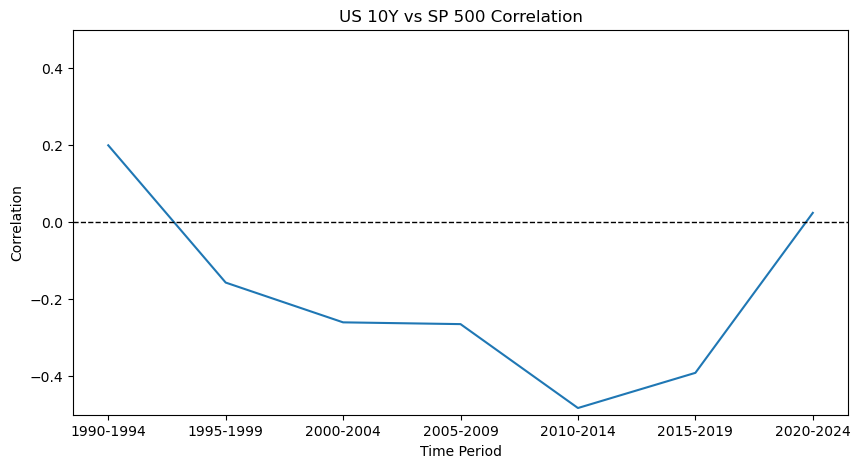

In [70]:
plt.figure(figsize = (10,5))
plt.title("US 10Y vs SP 500 Correlation")
plt.plot(time_frames, us_bond_vs_sp500_corrs)
plt.ylabel("Correlation")
plt.xlabel("Time Period")
plt.ylim(-0.5, 0.5)
plt.axhline(0, color='black', linestyle = '--', linewidth=1)
plt.show()

# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# We Extend Our Analysis to 1997 and 11 assets
# Assets: Gold, Oil, Copper, SP500, NIKKEI, FTSE, US 10Y, UK 10Y, JP 10Y, 
# US IG, US HY
# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

## Get Return Data

In [71]:
# Import Data Set
data = pd.read_csv("monthly_macro_data_1997.csv")
data = data.set_index("Date")
data = data.dropna()
original_columns = data.columns.to_list() # export column names for later use

In [72]:
# Generate Currency Performance
data["Yen Return"] = (-1) * ((data.USDJPY / data.USDJPY.shift(1)) - 1) # we multiply by negative 1 to get the yen returns
data["Pound Return"] = (data.GBPUSD / data.GBPUSD.shift(1)) - 1  

In [73]:
# Calculate Returns
data["Gold Return"] = (data.Gold  / data.Gold.shift(1)) - 1 
data["Oil Return"] = (data.WTI / data.WTI.shift(1)) -1
data["Copper Return"] = (data.Copper / data.Copper.shift(1)) -1
data["SP500 Return"] = (data.SP500 / data.SP500.shift(1)) - 1
data["Nikkei Return_Nom"] = ((data.NIKKEI / data.NIKKEI.shift(1)) - 1)
data["Nikkei Return_FX_Adj"] = data["Nikkei Return_Nom"] + data["Yen Return"] # add currency performance to return 
data["FTSE Return_Nom"] = (data.FTSE / data.FTSE.shift(1)) -1
data["FTSE Return_FX_Adj"] = data["FTSE Return_Nom"] + data["Pound Return"] # add currency performance to return

In [74]:
# Copy Bond Data for Return Calculation
US_10Y = data["US 10Y"].copy()
US_10Y = pd.DataFrame(US_10Y)
UK_10Y = data["UK 10Y"].copy()
UK_10Y = pd.DataFrame(UK_10Y)
JP_10Y = data["Japan 10Y"].copy()
JP_10Y = pd.DataFrame(JP_10Y)
US_IG = data["IG Bond Yield"].copy()
US_IG = pd.DataFrame(US_IG)
US_HY = data["HY Bond Yield"].copy()
US_HY = pd.DataFrame(US_HY)

In [75]:
# Basic Bond Return Calculator for 10Y Bond with monthly data (Note: we should be able to create a better approximation)
def Bond_Return_Calculator_10Y(yields):
    Returns = yields.copy()
    Returns['Return'] = 0.01 # placeholder
    safe_yield = 1e-6 # small value to avoid div-by-zero
    for i in range(0, len(yields)-1):
        old_yield = yields.iloc[i, 0] / 100
        new_yield = yields.iloc[i+1, 0] /100
        
        # protection for bonds with 0 yield
        if old_yield ==0:
            old_yield = safe_yield
            
        if new_yield == 0:
            new_yield = safe_yield
        
        pmt_old = (old_yield/2)*100
        new_price = -npf.pv(new_yield/2, 20, pmt_old, 100)
        bond_return = (new_price - 100 + old_yield*100/12) / 100
        Returns.iloc[i+1, 1] = bond_return
    return Returns

In [76]:
# Basic Bond Return Calculator for 7Y Bond with monthly data (Note: we should be able to create a better approximation)
def Bond_Return_Calculator_7Y(yields):
    Returns = yields.copy()
    Returns['Return'] = 0.01 # placeholder
    safe_yield = 1e-6 # small value to avoid div-by-zero
    for i in range(0, len(yields)-1):
        old_yield = yields.iloc[i, 0] / 100
        new_yield = yields.iloc[i+1, 0] /100
        
        # protection for bonds with 0 yield
        if old_yield ==0:
            old_yield = safe_yield
            
        if new_yield == 0:
            new_yield = safe_yield
        
        pmt_old = (old_yield/2)*100
        new_price = -npf.pv(new_yield/2, 14, pmt_old, 100)
        bond_return = (new_price - 100 + old_yield*100/12) / 100
        Returns.iloc[i+1, 1] = bond_return
    return Returns

In [77]:
# Calculate Bond Returns
US_10Y_Returns = Bond_Return_Calculator_10Y(US_10Y)
UK_10Y_Returns = Bond_Return_Calculator_10Y(UK_10Y)
JP_10Y_Returns = Bond_Return_Calculator_10Y(JP_10Y)
US_IG_Returns = Bond_Return_Calculator_7Y(US_IG)
US_HY_Returns = Bond_Return_Calculator_7Y(US_HY)

In [78]:
# Import Bond Return Data
data["US 10Y Return"] = US_10Y_Returns["Return"]
data["UK 10Y Return_Nom"] = UK_10Y_Returns["Return"]
data["UK 10Y Return_FX_Adj"] = data["UK 10Y Return_Nom"] + data["Pound Return"] # add currency performance to return 
data["JP 10Y Return_Nom"] = JP_10Y_Returns["Return"]
data["JP 10Y Return_FX_Adj"] = data["JP 10Y Return_Nom"] + data["Yen Return"] # add currency performance to return
data["US IG Return"] = US_IG_Returns["Return"]
data["US HY Return"] = US_HY_Returns["Return"]

In [79]:
# Delete first row because no return data available
data.drop(data.index[0], axis=0, inplace=True)

## Format Return Data

In [80]:
# Create Returns only DataFrame
returns = data.copy()
returns.drop(columns=original_columns, inplace=True)
returns.drop(columns=["Yen Return", "Pound Return", "UK 10Y Return_Nom", "JP 10Y Return_Nom",
                      "Nikkei Return_Nom", "FTSE Return_Nom"], inplace=True)
returns.rename(columns={'Gold Return' : 'Gold', "Oil Return" : "Oil", "Copper Return" : "Copper",
                        'SP500 Return' : 'SP500', 'US 10Y Return' : 'US 10Y', "UK 10Y Return_FX_Adj" : "UK 10Y",
                        "JP 10Y Return_FX_Adj" : "JP 10Y", "FTSE Return_FX_Adj" : "FTSE"
                       , "Nikkei Return_FX_Adj" : "Nikkei",
                       "US IG Return" : "US IG", "US HY Return" : "US HY"}, inplace=True)
returns.index = pd.to_datetime(returns.index) # set index to datetime
returns

,Gold,Oil,Copper,SP500,Nikkei,FTSE,US 10Y,UK 10Y,JP 10Y,US IG,US HY
Date,,,,,,,,,,,
1997-01-31,-0.037642,-0.003964,0.071835,0.030905,-0.100603,-0.026690,-0.001901,-0.057437,-0.048231,0.005908,0.010977
1997-02-28,-0.024021,-0.117390,-0.008504,0.041985,0.015847,0.024776,0.003267,0.048757,0.009951,0.002107,0.015491
1997-03-31,0.015090,-0.054554,0.005631,-0.007803,-0.053750,0.009885,-0.020208,-0.002095,-0.016580,-0.012291,-0.014148
1997-04-30,-0.020864,-0.060563,-0.012754,-0.035637,0.036996,0.014563,0.020161,-0.021544,-0.012081,0.015431,0.013652
1997-05-31,-0.001829,0.056853,0.051890,0.090532,0.131599,0.051648,0.009207,0.049381,0.054878,0.008813,0.024230
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30,-0.014479,-0.028337,-0.048066,0.023755,-0.009610,0.009637,0.011672,-0.026111,0.002623,0.010146,0.015751
2024-12-31,-0.001177,0.002430,-0.018271,0.013658,-0.002133,-0.027809,-0.028322,-0.011786,-0.049178,-0.011360,-0.016971
2025-01-31,0.023293,0.080148,0.007494,-0.005223,0.007559,0.055389,0.003817,-0.020289,0.002009,0.006772,0.023568


# Analyze Data

In [81]:
returns_copy = returns.copy()

In [82]:
# number of years in period 
returns_copy.index.year[-1] - returns_copy.index.year[0]

28

In [83]:
# So let's break it into four 7-year periods and 7 4-year periods

In [84]:
# create an analyzer to analyze the data
analyzer = ReturnAnalyzer(returns_copy)

In [85]:
# Break Data into 7 Year Blocks for Optimization and create optimizers as well as correlation matrices
# and average economic data figures  for each time period
block = 7 # specify number of years in each block 
start_year = returns_copy.index.year[0] # get first year
n_blocks = (returns_copy.index.year[-1] - start_year) // block # calculate number of blocks 
year_list = []
start_list = []
optimizer_list = []
corr_list = []
econ_list = []

for i in range(n_blocks):
    start_i = start_year+i*block
    end_i = start_i+block -1
    start_list.append(start_i)
    start_end = f"{start_i}_{end_i}"
    year_list.append(start_end)
    
    # splice data for each block using our splice method from the analyzer class
    block_returns = analyzer.splice_years(block, start_year=start_i)
    
    # create optimizer for each block using our optimizer class
    globals()[f"optimize_{start_end}"] = PortfolioOptimizer(block_returns)
    optimizer_list.append(globals()[f"optimize_{start_end}"])
    
    # create correlation matrix for each block
    corr = returns_copy.loc[(returns_copy.index.year >= start_i) & (returns_copy.index.year < end_i)].corr()
    corr_list.append(corr)
    
    # create tuple with average GDP and CPI for the time period
    avg_gdp = GDP.loc[(GDP.index >= start_i) & (GDP.index < end_i)].mean()
    avg_cpi = CPI.loc[(CPI.index >= start_i) & (CPI.index < end_i)].mean()
    econ = avg_gdp, avg_cpi
    econ_list.append(econ)

# The 7-year by asset returns and risks as follows:

In [86]:
rolled_returns = analyzer.roll_up_returns(block)
rolled_returns

,Gold_ann_return,Oil_ann_return,Copper_ann_return,SP500_ann_return,Nikkei_ann_return,FTSE_ann_return,US 10Y_ann_return,UK 10Y_ann_return,JP 10Y_ann_return,US IG_ann_return,...,Oil_ann_sharpe,Copper_ann_sharpe,SP500_ann_sharpe,Nikkei_ann_sharpe,FTSE_ann_sharpe,US 10Y_ann_sharpe,UK 10Y_ann_sharpe,JP 10Y_ann_sharpe,US IG_ann_sharpe,US HY_ann_sharpe
Time Frame,,,,,,,,,,,,,,,,,,,,,
1997-2003,0.014084,0.035140,-0.003994,0.054923,-0.086252,0.022222,0.077871,0.090605,0.028952,0.089464,...,0.124013,-0.026455,0.378745,-0.358615,0.146728,1.025465,0.950279,0.229712,1.862544,1.568076
2004-2010,0.191886,0.156953,0.225717,0.020025,0.029561,0.017526,0.051282,0.040929,0.041923,0.058749,...,0.489452,0.722139,0.138202,0.163311,0.093349,0.616798,0.437753,0.358128,0.922945,0.701491
2011-2017,-0.013489,-0.059842,-0.040880,0.115260,0.076295,0.017082,0.033205,0.031350,-0.031597,0.040432,...,-0.212706,-0.266720,1.288517,0.583511,0.119351,0.528982,0.371472,-0.305817,1.198981,1.013517
2018-2024,0.111373,0.027784,0.038623,0.123256,0.027603,-0.005666,-0.001294,-0.031897,-0.066877,0.019937,...,0.060480,0.237141,0.933383,0.161878,-0.033017,-0.016283,-0.276204,-0.658314,0.293932,0.436199


In [87]:
rolled_returns.to_csv("11_asset_7_year_risk_return.csv")

# Print optimized portfolios, asset correlations, and economic data for each time period

In [88]:
for optimizer, corr, econ in zip(optimizer_list, corr_list, econ_list):
    print(f"\nTime Period: {optimizer.start_year} - {optimizer.end_year}")
    optimizer.summary(show="Maximum Sharpe")
    print(f"\nAsset Correlations:")
    print(corr)
    print(f"\nEconomic Data:")
    print(f"Average Annual Real GDP Growth: {econ[0].values[0]:.2%}")
    print(f"Average CPI Growth: {econ[1].values[0]:.2%}")


Time Period: 1997 - 2003

Maximum Sharpe Portfolio:
Gold: 0.00%
Oil: 1.48%
Copper: 0.03%
SP500: 0.00%
Nikkei: 0.00%
FTSE: 0.00%
US 10Y: 0.00%
UK 10Y: 9.27%
JP 10Y: 0.00%
US IG: 59.34%
US HY: 29.89%
 Annualized Return: 10.10%, Volatility: 4.65%, Sharpe: 2.17

Asset Correlations:
            Gold       Oil    Copper     SP500    Nikkei      FTSE    US 10Y  \
Gold    1.000000  0.072943  0.143017 -0.194839  0.120810 -0.108668  0.052153   
Oil     0.072943  1.000000  0.260709  0.025426  0.263175 -0.195568  0.101195   
Copper  0.143017  0.260709  1.000000  0.184154  0.107231 -0.039063 -0.198241   
SP500  -0.194839  0.025426  0.184154  1.000000  0.391597  0.509375 -0.302709   
Nikkei  0.120810  0.263175  0.107231  0.391597  1.000000  0.420157 -0.118187   
FTSE   -0.108668 -0.195568 -0.039063  0.509375  0.420157  1.000000 -0.278892   
US 10Y  0.052153  0.101195 -0.198241 -0.302709 -0.118187 -0.278892  1.000000   
UK 10Y  0.126042 -0.068295 -0.045073 -0.089972  0.023694  0.064661  0.491946   


In [89]:
# Prepare lists to store data
weights_records = []
correlation_dfs = []
macro_records = []

# Loop through optimizers
for optimizer, corr, econ in zip(optimizer_list, corr_list, econ_list):
    time_period = f"{optimizer.start_year}-{optimizer.end_year}"

    # Get portfolio weights and performance
    weights, ann_return, ann_risk, sharpe = optimizer.optimize_max_sharpe()

    # Save portfolio weights
    weight_dict = {"Time Period": time_period, "Annualized Return": ann_return, "Annualized Risk": ann_risk, "Sharpe Ratio": sharpe}
    for asset, weight in zip(optimizer.assets, weights):
        weight_dict[asset] = weight
    weights_records.append(weight_dict)

    # Save correlation matrix
    corr.index.name = 'Asset'
    corr_dfs = corr.copy()
    corr_dfs['Time Period'] = time_period
    correlation_dfs.append(corr_dfs)

    # Save macroeconomic data
    macro_records.append({
        "Time Period": time_period,
        "Average Annual Real GDP Growth": econ[0].values[0],
        "Average CPI Growth": econ[1].values[0]
    })

# Export Portfolio Weights
weights_df = pd.DataFrame(weights_records)
weights_df.to_csv('11_asset_7_year_portfolio_weights_summary.csv', index=False)

# Export Correlation Matrices (one file per time period)
for corr_df in correlation_dfs:
    time_period = corr_df['Time Period'].iloc[0]
    corr_df.drop('Time Period', axis=1).to_csv(f'11_asset_7_year_correlation_matrix_{time_period}.csv')

# Export Macroeconomic Summary
macro_df = pd.DataFrame(macro_records)
macro_df.to_csv('11_asset_7_year_macroeconomic_summary.csv', index=False)

# Compare Optimized Portfolios against 60/40

In [90]:
# Get stock and bond return data
stocks_bonds_only = returns_copy[["SP500", "US 10Y"]].copy()
stocks_bonds_only_analyze = ReturnAnalyzer(stocks_bonds_only)
# Initialize lists to store the results for each period
rfr = 0
time_frames = []
opt_returns = []
opt_risks = []
opt_sharpes = []

bench_returns = []
bench_risks = []
bench_sharpes = []

for i in range(n_blocks):
    # Define year range
    start_i = start_year + i * block
    end_i = start_i + block - 1
    time_label = f"{start_i}-{end_i}"
    time_frames.append(time_label)

    # Get optimized max sharpe portfolio info
    optimizer = optimizer_list[i]
    w_opt, ret_opt, risk_opt, sharpe_opt = optimizer.optimize_max_sharpe()
    
    opt_returns.append(ret_opt)
    opt_risks.append(risk_opt)
    opt_sharpes.append(sharpe_opt)

    # Compute benchmark 60/40 portfolio
    sb_block_returns = stocks_bonds_only_analyze.splice_years(block, start_year=start_i)

    weights_6040 = np.array([0.6, 0.4])
    mu_6040 = (1 + sb_block_returns).prod() ** (1 / block) - 1  # annualized
    Sigma_6040 = sb_block_returns.cov().values * 12  # annualized

    ret_6040 = np.dot(weights_6040, mu_6040)
    var_6040 = np.dot(weights_6040.T, np.dot(Sigma_6040, weights_6040))
    vol_6040 = np.sqrt(var_6040)
    sharpe_6040 = (ret_6040 - rfr) / vol_6040

    bench_returns.append(ret_6040)
    bench_risks.append(vol_6040)
    bench_sharpes.append(sharpe_6040)

# Create DataFrame for comparison
comparison_df = pd.DataFrame({
    "Time Period": time_frames,
    "Optimized Return": opt_returns,
    "Optimized Risk": opt_risks,
    "Optimized Sharpe": opt_sharpes,
    "60/40 Return": bench_returns,
    "60/40 Risk": bench_risks,
    "60/40 Sharpe": bench_sharpes
})

# Format percentages and print
comparison_formatted = comparison_df.copy()
for col in ["Optimized Return", "Optimized Risk", "60/40 Return", "60/40 Risk"]:
    comparison_formatted[col] = comparison_formatted[col].apply(lambda x: f"{x:.2%}")

comparison_formatted["Optimized Sharpe"] = comparison_formatted["Optimized Sharpe"].apply(lambda x: f"{x:.2f}")
comparison_formatted["60/40 Sharpe"] = comparison_formatted["60/40 Sharpe"].apply(lambda x: f"{x:.2f}")
comparison_formatted.set_index("Time Period", inplace=True)
comparison_formatted

,Optimized Return,Optimized Risk,Optimized Sharpe,60/40 Return,60/40 Risk,60/40 Sharpe
Time Period,,,,,,
1997-2003,10.10%,4.65%,2.17,6.41%,8.48%,0.76
2004-2010,11.50%,7.21%,1.60,3.25%,8.27%,0.39
2011-2017,7.31%,4.17%,1.75,8.24%,4.90%,1.68
2018-2024,11.61%,8.98%,1.29,7.34%,8.34%,0.88


# Compare Custom Portfolio vs Optimized and 60/40

In [91]:
# Asset
optimizer_list[0].assets

['Gold',
 'Oil',
 'Copper',
 'SP500',
 'Nikkei',
 'FTSE',
 'US 10Y',
 'UK 10Y',
 'JP 10Y',
 'US IG',
 'US HY']

In [92]:
# Prior custom portfolio
# custom_weights = np.array([0.15, 0.00, 0.00, 0.35, 0.00, 0.00, 0.42, 0.08, 0.00])
# Gold, Oil, Copper, SP500, Nikkei, FTSE, US Bonds, UK Bonds, JP Bonds

# Build custom portfolio
custom_weights = np.array([0.20, 0.00, 0.00, 0.35, 0.00, 0.00, 0.30, 0.00, 0.00, 0.10, 0.05])
# Gold, Oil, Copper, SP500, Nikkei, FTSE, US Bonds, UK Bonds, JP Bonds, US IG, US HY

# Get risk and return metrics for each time period
custom_returns = []
custom_risks = []
custom_sharpes = []
for i in range(len(optimizer_list)):
    ret = optimizer_list[i].portfolio_return(custom_weights)
    risk = np.sqrt(optimizer_list[i].portfolio_variance(custom_weights))
    sharpe = (ret - rfr) / (risk)
    custom_returns.append(ret)
    custom_risks.append(risk)
    custom_sharpes.append(sharpe)

# Append summary table with custom portfolio performance
comparison_formatted["Custom Return"] = custom_returns
comparison_formatted["Custom Risk"] = custom_risks
comparison_formatted["Custom Sharpe"] = custom_sharpes

for col in ["Custom Return", "Custom Risk"]:
    comparison_formatted[col] = comparison_formatted[col].apply(lambda x: f"{x:.2%}")
comparison_formatted["Custom Sharpe"] = comparison_formatted["Custom Sharpe"].apply(lambda x: f"{x:.2f}")
comparison_formatted    

,Optimized Return,Optimized Risk,Optimized Sharpe,60/40 Return,60/40 Risk,60/40 Sharpe,Custom Return,Custom Risk,Custom Sharpe
Time Period,,,,,,,,,
1997-2003,10.10%,4.65%,2.17,6.41%,8.48%,0.76,6.09%,5.81%,1.05
2004-2010,11.50%,7.21%,1.60,3.25%,8.27%,0.39,7.15%,6.69%,1.07
2011-2017,7.31%,4.17%,1.75,8.24%,4.90%,1.68,5.58%,4.11%,1.36
2018-2024,11.61%,8.98%,1.29,7.34%,8.34%,0.88,6.97%,6.93%,1.01


In [93]:
comparison_formatted.to_csv('11_asset_7_year_portfolio_comparison.csv')

# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Now that we have looked at the data using 7  year periods, let's shorten our time horizon to 4 year and see if we can gain any new insights
# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [94]:
# Break Data into 4 Year Blocks for Optimization and create optimizers as well as correlation matrices
# and average economic data figures  for each time period
block = 4 # specify number of years in each block 
start_year = returns_copy.index.year[0] # get first year
n_blocks = (returns_copy.index.year[-1] - start_year) // block # calculate number of blocks 
year_list = []
start_list = []
optimizer_list = []
corr_list = []
econ_list = []

for i in range(n_blocks):
    start_i = start_year+i*block
    end_i = start_i+block -1
    start_list.append(start_i)
    start_end = f"{start_i}_{end_i}"
    year_list.append(start_end)
    
    # splice data for each block using our splice method from the analyzer class
    block_returns = analyzer.splice_years(block, start_year=start_i)
    
    # create optimizer for each block using our optimizer class
    globals()[f"optimize_{start_end}"] = PortfolioOptimizer(block_returns)
    optimizer_list.append(globals()[f"optimize_{start_end}"])
    
    # create correlation matrix for each block
    corr = returns_copy.loc[(returns_copy.index.year >= start_i) & (returns_copy.index.year < end_i)].corr()
    corr_list.append(corr)
    
    # create tuple with average GDP and CPI for the time period
    avg_gdp = GDP.loc[(GDP.index >= start_i) & (GDP.index < end_i)].mean()
    avg_cpi = CPI.loc[(CPI.index >= start_i) & (CPI.index < end_i)].mean()
    econ = avg_gdp, avg_cpi
    econ_list.append(econ)

# The 4-year by asset returns and risks as follows:

In [95]:
rolled_returns = analyzer.roll_up_returns(block)
rolled_returns

,Gold_ann_return,Oil_ann_return,Copper_ann_return,SP500_ann_return,Nikkei_ann_return,FTSE_ann_return,US 10Y_ann_return,UK 10Y_ann_return,JP 10Y_ann_return,US IG_ann_return,...,Oil_ann_sharpe,Copper_ann_sharpe,SP500_ann_sharpe,Nikkei_ann_sharpe,FTSE_ann_sharpe,US 10Y_ann_sharpe,UK 10Y_ann_sharpe,JP 10Y_ann_sharpe,US IG_ann_sharpe,US HY_ann_sharpe
Time Frame,,,,,,,,,,,,,,,,,,,,,
1997-2000,-0.073883,0.030393,-0.048988,0.156791,-0.099175,0.076397,0.085228,0.074814,0.024229,0.069271,...,0.101579,-0.296694,1.220510,-0.381245,0.550720,1.316701,0.748502,0.164836,1.746011,0.823984
2001-2004,0.129672,0.109846,0.141015,-0.025717,-0.027386,0.000718,0.062271,0.123532,0.036996,0.094687,...,0.409489,0.923124,-0.175920,-0.132237,0.004704,0.728893,1.395647,0.387809,1.668291,2.384385
2005-2008,0.165628,-0.011975,-0.002774,-0.075099,-0.028184,-0.086153,0.087981,-0.000982,0.042482,0.013730,...,-0.034945,-0.007716,-0.514988,-0.170598,-0.497097,1.124276,-0.011400,0.399546,0.210862,-0.383554
2009-2012,0.198671,0.209023,0.265604,0.128308,0.051563,0.096949,0.037271,0.101966,0.020827,0.123870,...,0.777672,1.195810,0.934650,0.283410,0.465422,0.445954,1.157888,0.175020,2.527608,2.123773
2013-2016,-0.089600,-0.123019,-0.081891,0.121078,0.083265,-0.019998,0.005932,-0.037831,-0.063005,0.021640,...,-0.381238,-0.540502,1.437478,0.636571,-0.143826,0.090904,-0.403211,-0.531726,0.618943,0.864322
2017-2020,0.125690,-0.024713,0.082495,0.132478,0.130377,-0.001637,0.056200,0.064476,0.028922,0.058850,...,-0.044514,0.552505,0.969194,0.844825,-0.009164,0.959207,0.789387,0.493811,1.019227,0.733884
2021-2024,0.092557,0.105070,0.034741,0.129334,-0.022305,0.034198,-0.048829,-0.085507,-0.131876,-0.012609,...,0.392416,0.209457,1.162131,-0.131514,0.231461,-0.563052,-0.649594,-1.092710,-0.184814,0.229412


In [96]:
rolled_returns.to_csv("11_asset_4_year_risk_return.csv")

# Print optimized portfolios, asset correlations, and economic data for each time period

In [97]:
for optimizer, corr, econ in zip(optimizer_list, corr_list, econ_list):
    print(f"\nTime Period: {optimizer.start_year} - {optimizer.end_year}")
    optimizer.summary(show="Maximum Sharpe")
    print(f"\nAsset Correlations:")
    print(corr)
    print(f"\nEconomic Data:")
    print(f"Average Annual Real GDP Growth: {econ[0].values[0]:.2%}")
    print(f"Average CPI Growth: {econ[1].values[0]:.2%}")


Time Period: 1997 - 2000

Maximum Sharpe Portfolio:
Gold: 0.00%
Oil: 0.00%
Copper: 0.00%
SP500: 19.00%
Nikkei: 0.00%
FTSE: 0.00%
US 10Y: 10.93%
UK 10Y: 0.00%
JP 10Y: 1.33%
US IG: 68.74%
US HY: 0.00%
 Annualized Return: 8.70%, Volatility: 4.13%, Sharpe: 2.11

Asset Correlations:
            Gold       Oil    Copper     SP500    Nikkei      FTSE    US 10Y  \
Gold    1.000000 -0.003804  0.122884 -0.127042  0.184952  0.047789 -0.069514   
Oil    -0.003804  1.000000  0.402959  0.035977  0.217410 -0.271279  0.035609   
Copper  0.122884  0.402959  1.000000  0.218528  0.183574 -0.148153 -0.091390   
SP500  -0.127042  0.035977  0.218528  1.000000  0.267900  0.419483 -0.198221   
Nikkei  0.184952  0.217410  0.183574  0.267900  1.000000  0.363738 -0.149285   
FTSE    0.047789 -0.271279 -0.148153  0.419483  0.363738  1.000000 -0.160968   
US 10Y -0.069514  0.035609 -0.091390 -0.198221 -0.149285 -0.160968  1.000000   
UK 10Y  0.053520 -0.012690  0.031525  0.092410  0.061271  0.069053  0.515902   



Maximum Sharpe Portfolio:
Gold: 29.94%
Oil: 10.99%
Copper: 0.00%
SP500: 59.06%
Nikkei: 0.00%
FTSE: 0.00%
US 10Y: 0.00%
UK 10Y: 0.00%
JP 10Y: 0.00%
US IG: 0.00%
US HY: 0.00%
 Annualized Return: 11.57%, Volatility: 8.37%, Sharpe: 1.38

Asset Correlations:
            Gold       Oil    Copper     SP500    Nikkei      FTSE    US 10Y  \
Gold    1.000000  0.093508  0.555333  0.325282  0.207238  0.206323  0.323675   
Oil     0.093508  1.000000  0.278519 -0.136953 -0.227922  0.123143 -0.226502   
Copper  0.555333  0.278519  1.000000  0.390317  0.013723  0.285827 -0.068590   
SP500   0.325282 -0.136953  0.390317  1.000000  0.349058  0.380881  0.293055   
Nikkei  0.207238 -0.227922  0.013723  0.349058  1.000000  0.652495  0.647276   
FTSE    0.206323  0.123143  0.285827  0.380881  0.652495  1.000000  0.524674   
US 10Y  0.323675 -0.226502 -0.068590  0.293055  0.647276  0.524674  1.000000   
UK 10Y  0.372401 -0.059759  0.135991  0.472034  0.761270  0.800289  0.794313   
JP 10Y  0.325590 -0.35500

In [98]:
# Prepare lists to store data
weights_records = []
correlation_dfs = []
macro_records = []

# Loop through optimizers
for optimizer, corr, econ in zip(optimizer_list, corr_list, econ_list):
    time_period = f"{optimizer.start_year}-{optimizer.end_year}"

    # Get portfolio weights and performance
    weights, ann_return, ann_risk, sharpe = optimizer.optimize_max_sharpe()

    # Save portfolio weights
    weight_dict = {"Time Period": time_period, "Annualized Return": ann_return, "Annualized Risk": ann_risk, "Sharpe Ratio": sharpe}
    for asset, weight in zip(optimizer.assets, weights):
        weight_dict[asset] = weight
    weights_records.append(weight_dict)

    # Save correlation matrix
    corr.index.name = 'Asset'
    corr_dfs = corr.copy()
    corr_dfs['Time Period'] = time_period
    correlation_dfs.append(corr_dfs)

    # Save macroeconomic data
    macro_records.append({
        "Time Period": time_period,
        "Average Annual Real GDP Growth": econ[0].values[0],
        "Average CPI Growth": econ[1].values[0]
    })

# Export Portfolio Weights
weights_df = pd.DataFrame(weights_records)
weights_df.to_csv('11_asset_4_year_portfolio_weights_summary.csv', index=False)

# Export Correlation Matrices (one file per time period)
for corr_df in correlation_dfs:
    time_period = corr_df['Time Period'].iloc[0]
    corr_df.drop('Time Period', axis=1).to_csv(f'11_asset_4_year_correlation_matrix_{time_period}.csv')

# Export Macroeconomic Summary
macro_df = pd.DataFrame(macro_records)
macro_df.to_csv('11_asset_4_year_macroeconomic_summary.csv', index=False)

# Compare Optimized Portfolios against 60/40

In [99]:
# Get stock and bond return data
stocks_bonds_only = returns_copy[["SP500", "US 10Y"]].copy()
stocks_bonds_only_analyze = ReturnAnalyzer(stocks_bonds_only)
# Initialize lists to store the results for each period
rfr = 0
time_frames = []
opt_returns = []
opt_risks = []
opt_sharpes = []

bench_returns = []
bench_risks = []
bench_sharpes = []

for i in range(n_blocks):
    # Define year range
    start_i = start_year + i * block
    end_i = start_i + block - 1
    time_label = f"{start_i}-{end_i}"
    time_frames.append(time_label)

    # Get optimized max sharpe portfolio info
    optimizer = optimizer_list[i]
    w_opt, ret_opt, risk_opt, sharpe_opt = optimizer.optimize_max_sharpe()
    
    opt_returns.append(ret_opt)
    opt_risks.append(risk_opt)
    opt_sharpes.append(sharpe_opt)

    # Compute benchmark 60/40 portfolio
    sb_block_returns = stocks_bonds_only_analyze.splice_years(block, start_year=start_i)

    weights_6040 = np.array([0.6, 0.4])
    mu_6040 = (1 + sb_block_returns).prod() ** (1 / block) - 1  # annualized
    Sigma_6040 = sb_block_returns.cov().values * 12  # annualized

    ret_6040 = np.dot(weights_6040, mu_6040)
    var_6040 = np.dot(weights_6040.T, np.dot(Sigma_6040, weights_6040))
    vol_6040 = np.sqrt(var_6040)
    sharpe_6040 = (ret_6040 - rfr) / vol_6040

    bench_returns.append(ret_6040)
    bench_risks.append(vol_6040)
    bench_sharpes.append(sharpe_6040)

# Create DataFrame for comparison
comparison_df = pd.DataFrame({
    "Time Period": time_frames,
    "Optimized Return": opt_returns,
    "Optimized Risk": opt_risks,
    "Optimized Sharpe": opt_sharpes,
    "60/40 Return": bench_returns,
    "60/40 Risk": bench_risks,
    "60/40 Sharpe": bench_sharpes
})

# Format percentages and print
comparison_formatted = comparison_df.copy()
for col in ["Optimized Return", "Optimized Risk", "60/40 Return", "60/40 Risk"]:
    comparison_formatted[col] = comparison_formatted[col].apply(lambda x: f"{x:.2%}")

comparison_formatted["Optimized Sharpe"] = comparison_formatted["Optimized Sharpe"].apply(lambda x: f"{x:.2f}")
comparison_formatted["60/40 Sharpe"] = comparison_formatted["60/40 Sharpe"].apply(lambda x: f"{x:.2f}")
comparison_formatted.set_index("Time Period", inplace=True)
comparison_formatted

,Optimized Return,Optimized Risk,Optimized Sharpe,60/40 Return,60/40 Risk,60/40 Sharpe
Time Period,,,,,,
1997-2000,8.70%,4.13%,2.11,12.82%,7.65%,1.68
2001-2004,16.62%,5.52%,3.01,0.95%,8.37%,0.11
2005-2008,10.62%,7.49%,1.42,-0.99%,8.48%,-0.12
2009-2012,17.21%,4.86%,3.55,9.19%,7.48%,1.23
2013-2016,8.25%,5.26%,1.57,7.50%,4.85%,1.55
2017-2020,8.52%,3.84%,2.22,10.20%,7.33%,1.39
2021-2024,11.57%,8.37%,1.38,5.81%,8.33%,0.70


# Compare Custom Portfolio vs Optimized and 60/40

In [100]:
# Prior custom portfolio
# custom_weights = np.array([0.15, 0.00, 0.00, 0.35, 0.00, 0.00, 0.42, 0.08, 0.00])
# Gold, Oil, Copper, SP500, Nikkei, FTSE, US Bonds, UK Bonds, JP Bonds

# Build custom portfolio
custom_weights = np.array([0.20, 0.00, 0.00, 0.35, 0.00, 0.00, 0.30, 0.00, 0.00, 0.10, 0.05])
# Gold, Oil, Copper, SP500, Nikkei, FTSE, US Bonds, UK Bonds, JP Bonds, US IG, US HY

# Get risk and return metrics for each time period
custom_returns = []
custom_risks = []
custom_sharpes = []
for i in range(len(optimizer_list)):
    ret = optimizer_list[i].portfolio_return(custom_weights)
    risk = np.sqrt(optimizer_list[i].portfolio_variance(custom_weights))
    sharpe = (ret - rfr) / (risk)
    custom_returns.append(ret)
    custom_risks.append(risk)
    custom_sharpes.append(sharpe)

# Append summary table with custom portfolio performance
comparison_formatted["Custom Return"] = custom_returns
comparison_formatted["Custom Risk"] = custom_risks
comparison_formatted["Custom Sharpe"] = custom_sharpes

for col in ["Custom Return", "Custom Risk"]:
    comparison_formatted[col] = comparison_formatted[col].apply(lambda x: f"{x:.2%}")
comparison_formatted["Custom Sharpe"] = comparison_formatted["Custom Sharpe"].apply(lambda x: f"{x:.2f}")
comparison_formatted    

,Optimized Return,Optimized Risk,Optimized Sharpe,60/40 Return,60/40 Risk,60/40 Sharpe,Custom Return,Custom Risk,Custom Sharpe
Time Period,,,,,,,,,
1997-2000,8.70%,4.13%,2.11,12.82%,7.65%,1.68,7.51%,5.20%,1.44
2001-2004,16.62%,5.52%,3.01,0.95%,8.37%,0.11,5.58%,6.15%,0.91
2005-2008,10.62%,7.49%,1.42,-0.99%,8.48%,-0.12,3.20%,7.30%,0.44
2009-2012,17.21%,4.86%,3.55,9.19%,7.48%,1.23,12.18%,5.16%,2.36
2013-2016,8.25%,5.26%,1.57,7.50%,4.85%,1.55,3.18%,4.31%,0.74
2017-2020,8.52%,3.84%,2.22,10.20%,7.33%,1.39,9.87%,5.89%,1.68
2021-2024,11.57%,8.37%,1.38,5.81%,8.33%,0.70,4.91%,7.07%,0.69


In [101]:
comparison_formatted.to_csv('11_asset_4_year_portfolio_comparison.csv')

# As expected, as we get to more granular data and more assets to optimize on, the optimal portfolio sharpe increases as we "curve fit" and our all-weather portfolio does not perform as well or beat the 60/40 in all time periods. However we can gained some valuable insights in this exercise

# The Custom portfolio performs well, but does lag the 60/40 in 2 out of 6 of the periods (1997-2000 and 2013-2016), while outperforming it strongly in 3 periods (2001-2004, 2005-2008, 2009-2012) 

# Next steps are to incorporate market expectations of economic data such as GDP and Inflation Expectations, and perhaps we can use Machine Learning to take these economic data and use the change in expectations to learn how best to construct a portfolio given the macro and market dynamics